<img align="left" src=https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=200 style="padding: 10px">
<br>
<b>Operations Rehearsal Analysis Notebook</b> <br>
Contact author: Meredith Rawls<br>
Last verified to run: August 21, 2024<br>
LSST Science Piplines version: w_2024_31<br>
Container Size: Large <br>

# PREOPS-5281: Investigate diaSources in OR4

In OR3, we saw nearly 2x as many diaSources in prompt processing as in nightly validation, and the reason was unclear. Investigate this more thoroughly in OR4 and figure out what is happening in the case of a discrepency.

### Counting diaSources

Nightly validation did not run difference imaging in OR4, so we used a full DRP reprocessing to compare to PP. While all datasets made it through DRP, some did not make it through PP. Therefore, we consider the PP success datasets only.

PP injects sky sources and filters out some diaSources in certain cases. DRP presently does not. For a true apples-to-apples comparison, we find the following

- PP: 11.4M diaSrc = 9.7M diaSrcTable + 1.4M rejected sky sources + 200K long trailed sources
- DRP: 13.0M diaSrc = 13.0M diaSrcTable

Thus, we should compare the 13.0M DRP number to the 9.7M + 200K = 9.9M PP number. **There are 3.1M more diaSources in DRP than in PP!**

### Conclusions

OR4 images were generated with of order 250 variable diaSources per detector, so we would naively expect to find about 1000 diaSources per detector. Thus, a diaSource-per-detector distribution that has a tail out to maybe 5000 is not unreasonable, but we shouldn't expect to see any detectors with way more than this.

However, **there are about 160 visit+detectors with more than 8000 diaSources in DRP, and only 1 in PP**. A list of these is available on the Jira ticket. The rest of this notebook takes a closer look at one of these: visit 7024062700702, detector 2.

* In DRP, detectAndMeasureTask finds about 17% of all pixels are DETECTED. In PP, this is less than 1%.
* Interestingly, in DRP all of the DETECTED areas are also masked as STREAK, but this is most likely a symptom of runaway detection, not a cause.
* In PP, there is a NO_DATA region in the template that is correctly propagated to the difference image. DRP uses different templates and has no empty region.
* To investigate whether the source of the problem originates in the template, we re-ran a single PP visit with the DRP template, and got results comparable to the original PP run (but with no NO_DATA region). This means the problem does NOT originate in the template.

**We have not yet tracked down the reason that DRP single frame + difference imaging is making so many extraneous detections.** It is worth noting that PP used calibrateImage in single frame processing while DRP used characterizeImage + calibrate, and that the configs for subtractImage and detectAndMeasure (manually inspected) are virtually identical.

To catch failures like this in the future, we ought to look at the `detected_mask_fraction` metric and ensure it is below 10% unless the field is _very_ crowded.

## Imports and loading data

In [1]:
%matplotlib widget
import numpy as np
import pyarrow as pa
from sqlalchemy import func, select
import yaml
import functools
import operator
import matplotlib.pyplot as plt
import pandas as pd
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize, MinMaxInterval, LogStretch
from astropy.table import Table, join
import lsst.daf.butler as dafButler
from lsst.daf.butler import DatasetNotFoundError
from lsst.pipe.base import Instrument
from lsst.analysis.ap import apdb
from lsst.analysis.ap import legacyPlotUtils as pla
from lsst.analysis.ap import PlotImageSubtractionCutoutsConfig, PlotImageSubtractionCutoutsTask
import lsst.afw.display as afwDisplay
import lsst.display.astrowidgets
afwDisplay.setDefaultBackend('astrowidgets')

In [3]:
repo = 'embargo_or4'
instrument = 'LSSTComCamSim'
skymap = 'ops_rehersal_prep_2k_v1'
nv_collections = ['LSSTComCamSim/runs/nightlyValidation/20240625/w_2024_25/DM-44966',
                  'LSSTComCamSim/runs/nightlyValidation/20240626/w_2024_25/DM-44966',
                  'LSSTComCamSim/runs/nightlyValidation/20240627/w_2024_25/DM-44966']
drp_collections = 'LSSTComCamSim/runs/DRP/OR4/w_2024_25/DM-45066'
pp_collections = ['LSSTComCamSim/prompt/output-2024-06-25',
                  'LSSTComCamSim/prompt/output-2024-06-26',
                  'LSSTComCamSim/prompt/output-2024-06-27']
pp_url = 'rubin@usdf-prompt-processing-dev.slac.stanford.edu/lsst-devl'
pp_namespace = 'pp_ppdb_lsstcomcamsim_or4'

In [4]:
nv_butler = dafButler.Butler(repo, collections=nv_collections, instrument=instrument, skymap=skymap)
drp_butler = dafButler.Butler(repo, collections=drp_collections, instrument=instrument, skymap=skymap)

In [5]:
pp_butler = dafButler.Butler(repo, collections=pp_collections, instrument=instrument, skymap=skymap)

In [6]:
ppdb = apdb.ApdbPostgresQuery(instrument='LSSTComCamSim', url=pp_url, namespace=pp_namespace)

In [7]:
def printExistingDatasetTypes(butler, collections):
    """List datasetTypes that exist in a given Butler and collections."""
    registry = butler.registry
    for datasetType in registry.queryDatasetTypes():
        if registry.queryDatasets(datasetType, collections=collections).any(execute=False, exact=False):
            # Limit search results to the data products
            if ('_config' not in datasetType.name) and ('_log' not in datasetType.name) and \
               ('_metadata' not in datasetType.name) and ('_resource_usage' not in datasetType.name) and \
               ('wholeSky' not in datasetType.name) and \
               ('dia' in datasetType.name or 'Dia' in datasetType.name or 'goodSeeingDiff' in datasetType.name):
                print(datasetType)

In [21]:
printExistingDatasetTypes(nv_butler, nv_collections)

In [22]:
printExistingDatasetTypes(drp_butler, drp_collections)

DatasetType('goodSeeingDiff_diaSrc_schema', {}, SourceCatalog)
DatasetType('goodSeeingDiff_templateExp', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF)
DatasetType('goodSeeingDiff_differenceTempExp', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF)
DatasetType('goodSeeingDiff_matchedExp', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF)
DatasetType('goodSeeingDiff_psfMatchKernel', {band, instrument, day_obs, detector, physical_filter, visit}, MatchingKernel)
DatasetType('goodSeeingDiff_diaSrc', {band, instrument, day_obs, detector, physical_filter, visit}, SourceCatalog)
DatasetType('goodSeeingDiff_differenceExp', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF)
DatasetType('goodSeeingDiff_diaSrcTable', {band, instrument, day_obs, detector, physical_filter, visit}, DataFrame)
DatasetType('forcedSourceOnDiaObjectTable', {skymap, tract, patch}, DataFrame)
DatasetType('goodSeeingDiff_asso

In [23]:
printExistingDatasetTypes(pp_butler, pp_collections)

DatasetType('goodSeeingDiff_templateExp', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF)
DatasetType('goodSeeingDiff_differenceTempExp', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF)
DatasetType('goodSeeingDiff_matchedExp', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF)
DatasetType('goodSeeingDiff_psfMatchKernel', {band, instrument, day_obs, detector, physical_filter, visit}, MatchingKernel)
DatasetType('goodSeeingDiff_diaSrc', {band, instrument, day_obs, detector, physical_filter, visit}, SourceCatalog)
DatasetType('goodSeeingDiff_differenceExp', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF)
DatasetType('goodSeeingDiff_candidateDiaSrc', {band, instrument, day_obs, detector, physical_filter, visit}, SourceCatalog)
DatasetType('goodSeeingDiff_longTrailedSrc', {band, instrument, day_obs, detector, physical_filter, visit}, ArrowAstropy)
DatasetType('goodSeeingDiff_rejectedDiaSrc',

## Count diaSources to compare PP with DRP

We need to ensure we have the same datasets. DRP succeeded on all inputs, but PP had some failures, as documented in [the log](https://confluence.lsstcorp.org/display/DM/Prompt+Processing+with+LSSTComCamSim+ops-rehearsal-4). 

In [8]:
fullVisitDetectorList_science_pp = [item.dataId for item in pp_butler.registry.queryDatasets('initial_pvi')]
fullVisitDetectorList_science_drp = [item.dataId for item in drp_butler.registry.queryDatasets('calexp')]

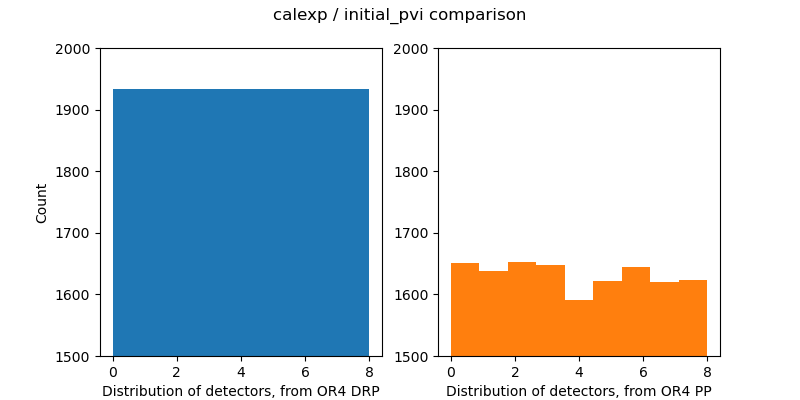

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle('calexp / initial_pvi comparison')
ax1.hist([item['detector'] for item in fullVisitDetectorList_science_drp], bins=9)
ax1.set_xlabel('Distribution of detectors, from OR4 DRP')
ax1.set_ylim(1500, 2000)
ax1.set_ylabel('Count')
ax2.hist([item['detector'] for item in fullVisitDetectorList_science_pp], bins=9, color='C1')
ax2.set_xlabel('Distribution of detectors, from OR4 PP')
ax2.set_ylim(1500, 2000)
#ax2.set_ylabel('Count')
plt.show()

In [10]:
fullVisitDetectorList_diaSrcTable_pp = [item.dataId for item in pp_butler.registry.queryDatasets('goodSeeingDiff_diaSrcTable')]
fullVisitDetectorList_diaSrcTable_drp = [item.dataId for item in drp_butler.registry.queryDatasets('goodSeeingDiff_diaSrcTable')]

fullVisitDetectorList_diaSrc_pp = [item.dataId for item in pp_butler.registry.queryDatasets('goodSeeingDiff_diaSrc')]
fullVisitDetectorList_diaSrc_drp = [item.dataId for item in drp_butler.registry.queryDatasets('goodSeeingDiff_diaSrc')]

print('DRP')
print(len(fullVisitDetectorList_science_drp), 'science datasets')
print(len(fullVisitDetectorList_diaSrc_drp), 'diaSrc datasets')
print(len(fullVisitDetectorList_diaSrcTable_drp), 'diaSrcTable datasets')

print('\nPP')
print(len(fullVisitDetectorList_science_pp), 'science datasets')
print(len(fullVisitDetectorList_diaSrc_pp), 'diaSrc datasets')
print(len(fullVisitDetectorList_diaSrcTable_pp), 'diaSrcTable datasets')

DRP
17397 science datasets
17397 diaSrc datasets
17397 diaSrcTable datasets

PP
14690 science datasets
14662 diaSrc datasets
14662 diaSrcTable datasets


There are 2707 "missing" PP datasets compared to the complete DRP reprocessing. The total number of successfully processed PP datasets agrees with  [the log](https://confluence.lsstcorp.org/display/DM/Prompt+Processing+with+LSSTComCamSim+ops-rehearsal-4).

In [31]:
def diaSourceCounterSimple(dataIdList, butler, datasetType):
    # TODO: option to exclude certain flagged sources
    df = pd.DataFrame()
    for dataId in dataIdList:
        row = {}
        row['visit'] = dataId['visit']
        row['detector'] = dataId['detector']
        try:
            row['nDiaSources'] = len(butler.get(datasetType, dataId=dataId))    
        except DatasetNotFoundError:
            print(f'Could not load {dataId}')
            row['nDiaSources'] = np.nan
            continue
        df = df._append(row, ignore_index=True)
    return df

In [32]:
dataIdTestList = fullVisitDetectorList_diaSrcTable_pp[0:2]
drp_testdf = diaSourceCounterSimple(dataIdTestList, drp_butler, 'goodSeeingDiff_diaSrcTable')
pp_testdf = diaSourceCounterSimple(dataIdTestList, pp_butler, 'goodSeeingDiff_diaSrcTable')

In [33]:
drp_testdf

visit  detector  nDiaSources
0  7024062500134         3         1172
1  7024062500132         2         1918

In [34]:
pp_testdf

visit  detector  nDiaSources
0  7024062500134         3         1002
1  7024062500132         2         1588

In [35]:
print(drp_testdf['nDiaSources'].sum(), pp_testdf['nDiaSources'].sum())

3090 2590


## To count diaSources in DRP and PP, we will use the PP "fullVisitDetectorList" for both

Each of these counting operations takes about 8 minutes

In [36]:
drp_diaSourceTable = diaSourceCounterSimple(fullVisitDetectorList_diaSrcTable_pp, drp_butler, 'goodSeeingDiff_diaSrcTable')

In [37]:
pp_diaSourceTable = diaSourceCounterSimple(fullVisitDetectorList_diaSrcTable_pp, pp_butler, 'goodSeeingDiff_diaSrcTable')

In [72]:
drp_diaSourceTable_total = drp_diaSourceTable['nDiaSources'].sum()
drp_diaSourceTable_total

13027943

In [73]:
pp_diaSource_total = pp_diaSourceTable['nDiaSources'].sum()
pp_diaSource_total

9717981

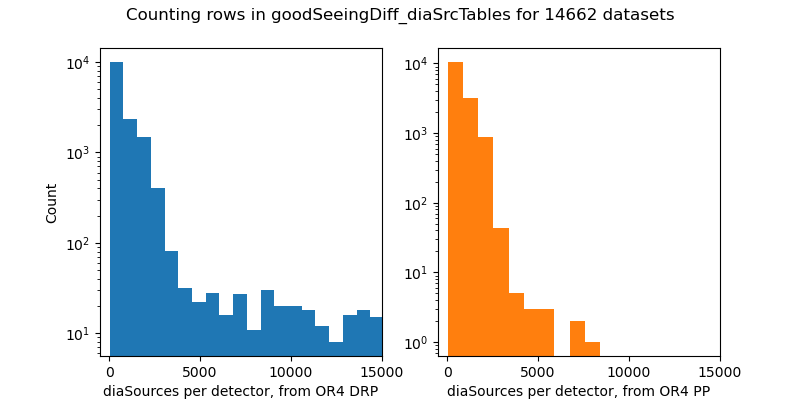

In [189]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle('Counting rows in goodSeeingDiff_diaSrcTables for 14662 datasets')
ax1.hist(drp_diaSourceTable['nDiaSources'], log=True, bins=20)
ax1.set_xlabel('diaSources per detector, from OR4 DRP')
ax1.set_ylabel('Count')
ax1.set_xlim([-500, 15000])
ax2.hist(pp_diaSourceTable['nDiaSources'], color='C1', log=True)
ax2.set_xlabel('diaSources per detector, from OR4 PP')
#ax2.set_ylabel('Count')
ax2.set_xlim([-500, 15000])
plt.show()

In [51]:
drp_byvisit = drp_diaSourceTable.groupby('visit')
pp_byvisit = pp_diaSourceTable.groupby('visit')
drp_byvisit.sum()

detector  nDiaSources
visit                               
7024062500130        36        13038
7024062500131        36        15414
7024062500132        21        10462
7024062500133        25         9181
7024062500134        36        10986
...                 ...          ...
7024062700769        36         2121
7024062700770        36         1695
7024062700771        36         2098
7024062700772        36         2208
7024062700773        36         3807

[1863 rows x 2 columns]

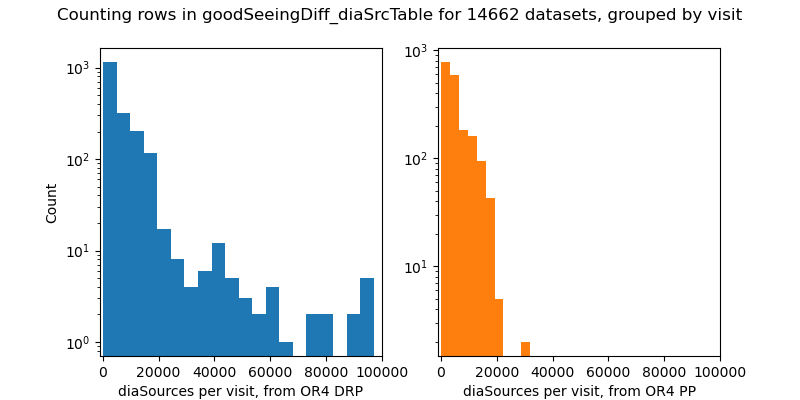

In [193]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle('Counting rows in goodSeeingDiff_diaSrcTable for 14662 datasets, grouped by visit')
ax1.hist(drp_byvisit['nDiaSources'].sum(), log=True, bins=20)
ax1.set_xlabel('diaSources per visit, from OR4 DRP')
ax1.set_ylabel('Count')
ax1.set_xlim([-1000, 100000])
ax2.hist(pp_byvisit['nDiaSources'].sum(), color='C1', log=True)
ax2.set_xlabel('diaSources per visit, from OR4 PP')
#ax2.set_ylabel('Count')
ax2.set_xlim([-1000, 100000])
plt.show()

So far, we have considered matching dataIds in DRP and PP and used only the `diaSourceTable` data product. However, this is a small undercount, because the longTrailed diaSources have been shunted into a different data product. (Independently, sky sources were injected and subsequently removed, so we don't have to worry about those for now.)

I did the following counting in now-deleted-very-slow-boring cells:

* PP diaSrc 11398539 (PP diaSrcTable + sky sources)
* PP rejectedDiaSrc 1466200 (just the sky sources)
* PP longTrailedSrc 214358
* DRP diaSrc 13027943 (same as DRP diaSrcTable)

In [133]:
pp_longTrailedSrc = diaSourceCounterSimple(fullVisitDetectorList_diaSrcTable_pp, pp_butler, 'goodSeeingDiff_longTrailedSrc')  # SLOW

In [135]:
pp_longTrailedSrc_total = pp_longTrailedSrc['nDiaSources'].sum()
pp_longTrailedSrc_total

214358

In [137]:
pp_diaSourceAndLongTrailed = pd.concat([pp_diaSourceTable, pp_longTrailedSrc])

Add band information to the dataframes so we can also make plots with that information

In [156]:
bandList = []
for index, item in pp_diaSourceAndLongTrailed.iterrows():
    band = list(pp_butler.registry.queryDataIds(dimensions=('band'), where=f"visit={item['visit']} AND detector={item['detector']}"))[0]['band']
    bandList.append(band)
pp_diaSourceAndLongTrailed['band'] = bandList

In [157]:
pp_diaSourceAndLongTrailed

visit  detector  nDiaSources band
0      7024062500134         3         1002    r
1      7024062500132         2         1588    r
2      7024062500136         6         1391    r
3      7024062500139         6         1426    r
4      7024062500137         4         1358    r
...              ...       ...          ...  ...
14657  7024062700773         5           46    i
14658  7024062700773         3            2    i
14659  7024062700773         4           39    i
14660  7024062700773         7            1    i
14661  7024062700773         2           20    i

[29324 rows x 4 columns]

In [158]:
bandList_drp = []
for index, item in drp_diaSourceTable.iterrows():
    band = list(drp_butler.registry.queryDataIds(dimensions=('band'), where=f"visit={item['visit']} AND detector={item['detector']}"))[0]['band']
    bandList_drp.append(band)
drp_diaSourceTable['band'] = bandList_drp

In [160]:
drp_diaSourceTable

visit  detector  nDiaSources band
0      7024062500134         3         1172    r
1      7024062500132         2         1918    r
2      7024062500136         6         1918    r
3      7024062500139         6         2088    r
4      7024062500137         4         1368    r
...              ...       ...          ...  ...
14657  7024062700773         5          169    i
14658  7024062700773         3          416    i
14659  7024062700773         4          153    i
14660  7024062700773         7         1013    i
14661  7024062700773         2          200    i

[14662 rows x 4 columns]

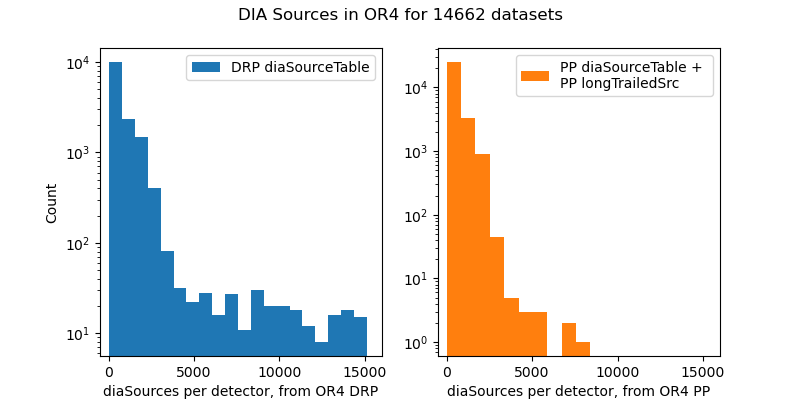

In [199]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.hist(drp_diaSourceTable['nDiaSources'], log=True, bins=20, label='DRP diaSourceTable')
ax1.set_xlabel('diaSources per detector, from OR4 DRP')
ax1.set_ylabel('Count')
ax1.set_xlim([-500, 16000])
ax1.legend()
ax2.hist(pp_diaSourceAndLongTrailed['nDiaSources'], color='C1', log=True, label=f'PP diaSourceTable + \nPP longTrailedSrc')
ax2.set_xlabel('diaSources per detector, from OR4 PP')
#ax2.set_ylabel('Count')
ax2.set_xlim([-500, 16000])
ax2.legend()
fig.suptitle('DIA Sources in OR4 for 14662 datasets')
plt.show()

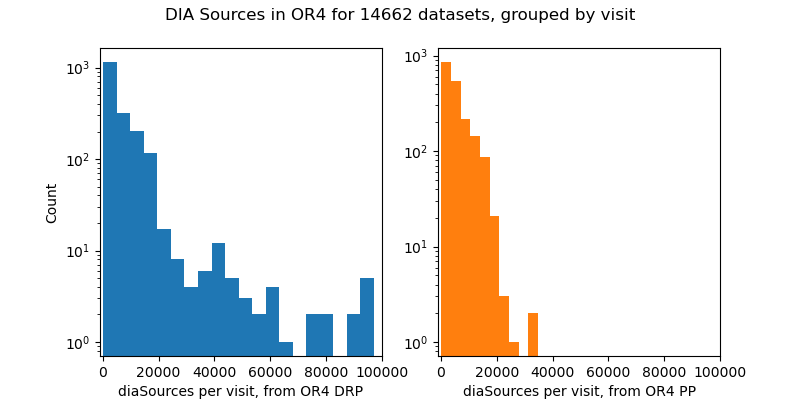

In [200]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle('DIA Sources in OR4 for 14662 datasets, grouped by visit')
ax1.hist(drp_diaSourceTable.groupby('visit')['nDiaSources'].sum(), log=True, bins=20, label='DRP diaSourceTable')
ax1.set_xlabel('diaSources per visit, from OR4 DRP')
ax1.set_ylabel('Count')
ax1.set_xlim([-1000, 100000])
ax2.hist(pp_diaSourceAndLongTrailed.groupby('visit')['nDiaSources'].sum(), color='C1', log=True, label=f'PP diaSourceTable + \nPP longTrailedSrc')
ax2.set_xlabel('diaSources per visit, from OR4 PP')
#ax2.set_ylabel('Count')
ax2.set_xlim([-1000, 100000])
plt.show()

In [164]:
drp_byband = drp_diaSourceTable.groupby('band')
pp_byband = pp_diaSourceAndLongTrailed.groupby('band')

In [170]:
drp_byband['nDiaSources'].sum()

band
g    4342230
i    4028527
r    4657186
Name: nDiaSources, dtype: int64

In [172]:
pp_byband['nDiaSources'].sum()

band
g    3300460
i    3220248
r    3411631
Name: nDiaSources, dtype: int64

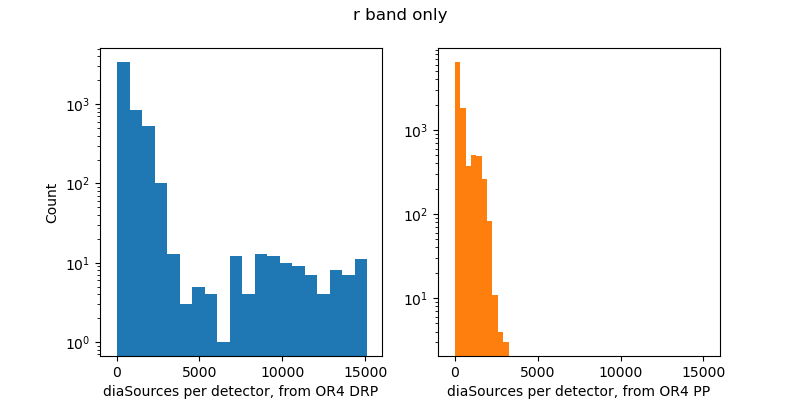

In [181]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle('r band only')
ax1.hist(drp_diaSourceTable.loc[drp_diaSourceTable['band'] == 'r', 'nDiaSources'], log=True, bins=20)
ax1.set_xlabel('diaSources per detector, from OR4 DRP')
ax1.set_ylabel('Count')
ax1.set_xlim([-1000, 16000])
ax2.hist(pp_diaSourceAndLongTrailed.loc[pp_diaSourceAndLongTrailed['band'] == 'r' , 'nDiaSources'], color='C1', log=True)
ax2.set_xlabel('diaSources per detector, from OR4 PP')
#ax2.set_ylabel('Count')
ax2.set_xlim([-1000, 16000])
plt.show()

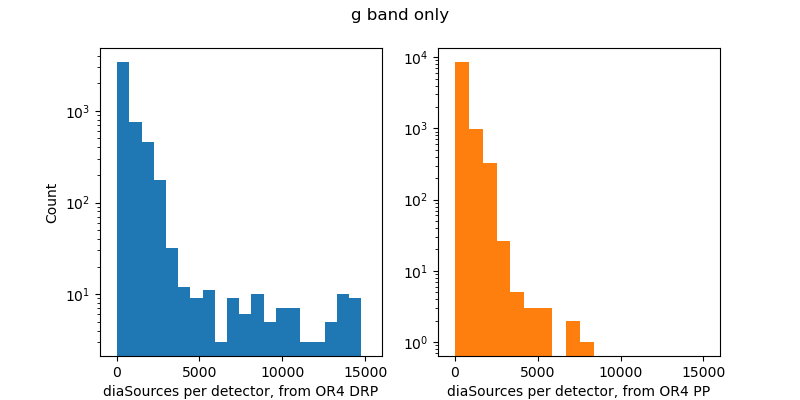

In [188]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle('g band only')
ax1.hist(drp_diaSourceTable.loc[drp_diaSourceTable['band'] == 'g', 'nDiaSources'], log=True, bins=20)
ax1.set_xlabel('diaSources per detector, from OR4 DRP')
ax1.set_ylabel('Count')
ax1.set_xlim([-1000, 16000])
ax2.hist(pp_diaSourceAndLongTrailed.loc[pp_diaSourceAndLongTrailed['band'] == 'g' , 'nDiaSources'], color='C1', log=True)
ax2.set_xlabel('diaSources per detector, from OR4 PP')
#ax2.set_ylabel('Count')
ax2.set_xlim([-1000, 16000])
plt.show()

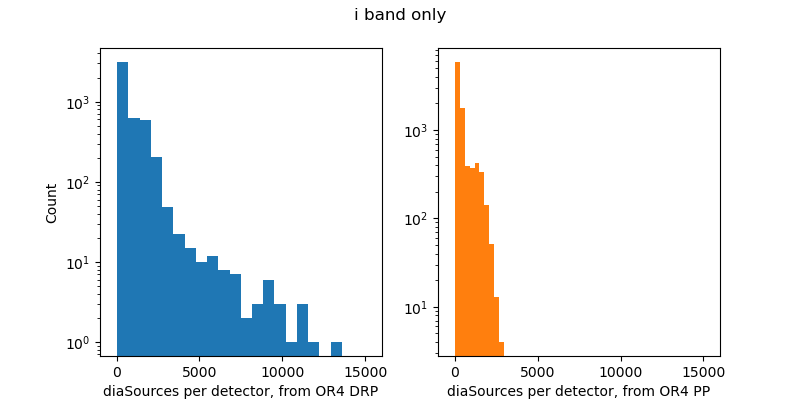

In [186]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle('i band only')
ax1.hist(drp_diaSourceTable.loc[drp_diaSourceTable['band'] == 'i', 'nDiaSources'], log=True, bins=20)
ax1.set_xlabel('diaSources per detector, from OR4 DRP')
ax1.set_ylabel('Count')
ax1.set_xlim([-1000, 16000])
ax2.hist(pp_diaSourceAndLongTrailed.loc[pp_diaSourceAndLongTrailed['band'] == 'i' , 'nDiaSources'], color='C1', log=True)
ax2.set_xlabel('diaSources per detector, from OR4 PP')
#ax2.set_ylabel('Count')
ax2.set_xlim([-1000, 16000])
plt.show()

## Look at spatial regions where DRP datasets have lots of diaSources, but PP datasets have a reasonable number

Let's see what information is available in a dataId corresponding to one diaSrcTable dataset

In [91]:
fullVisitDetectorList_diaSrcTable_drp[0]

{instrument: 'LSSTComCamSim', detector: 8, visit: 7024062700487, band: 'r', day_obs: 20240627, physical_filter: 'r_03'}

### Looking up patches and tracts that correspond to certain visits and detectors

This dataId does not include patch or tract, which we might want to know so we can evaluate if diaSource counts differ in different sky regions. Let's retrieve that too

In [93]:
for item in list(set(list(drp_butler.registry.queryDataIds(dimensions=('visit', 'detector', 'tract', 'patch'),
                                               where='visit=7024062700487 AND detector=8')))):
    print(item['tract'], item['patch'])

6568 147
6568 94
6568 131
6568 96
6568 164
6568 129
6568 111
6568 148
6568 113
6568 146
6568 128
6568 115
6568 95
6568 163
6568 97
6568 130
6568 112
6568 132
6568 114
6568 79


In [129]:
def makeDataIdDictWithPatches(visitDetectorList, butler):
    new_fullVisitDetectorList = []
    for item in visitDetectorList:
        valid_patches = []
        new_item = {}
        query = set(list(butler.registry.queryDataIds(dimensions=('visit', 'detector', 'tract', 'patch'),
                                                      where=f"visit={item['visit']} AND detector={item['detector']}")))
        for result in query:
            valid_patches.append({'tract': result['tract'], 'patch': result['patch']})
        for key, value in zip(item.mapping, item._values):
            new_item[key] = value
        new_item['valid_patches'] = valid_patches
        new_fullVisitDetectorList.append(new_item)
    return new_fullVisitDetectorList

In [131]:
test_fullVisitDetectorList = makeDataIdDictWithPatches(fullVisitDetectorList_diaSrcTable_drp[0:2], drp_butler)

In [132]:
test_fullVisitDetectorList

[{'instrument': 'LSSTComCamSim',
  'detector': 8,
  'visit': 7024062700487,
  'band': 'r',
  'day_obs': 20240627,
  'physical_filter': 'r_03',
  'valid_patches': [{'tract': 6568, 'patch': 147},
   {'tract': 6568, 'patch': 94},
   {'tract': 6568, 'patch': 131},
   {'tract': 6568, 'patch': 96},
   {'tract': 6568, 'patch': 164},
   {'tract': 6568, 'patch': 129},
   {'tract': 6568, 'patch': 111},
   {'tract': 6568, 'patch': 148},
   {'tract': 6568, 'patch': 113},
   {'tract': 6568, 'patch': 146},
   {'tract': 6568, 'patch': 128},
   {'tract': 6568, 'patch': 115},
   {'tract': 6568, 'patch': 95},
   {'tract': 6568, 'patch': 163},
   {'tract': 6568, 'patch': 97},
   {'tract': 6568, 'patch': 130},
   {'tract': 6568, 'patch': 112},
   {'tract': 6568, 'patch': 132},
   {'tract': 6568, 'patch': 114},
   {'tract': 6568, 'patch': 79}]},
 {'instrument': 'LSSTComCamSim',
  'detector': 4,
  'visit': 7024062500607,
  'band': 'i',
  'day_obs': 20240625,
  'physical_filter': 'i_06',
  'valid_patches': [

In [201]:
fullVisitDetectorPatchList = makeDataIdDictWithPatches(fullVisitDetectorList_diaSrcTable_pp, pp_butler)

In [305]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(drp_diaSourceTable.loc[drp_diaSourceTable['nDiaSources'] > 8000])
drp_diaSourceTable.loc[drp_diaSourceTable['nDiaSources'] > 8000]

visit  detector  nDiaSources band
11574  7024062700294         0         8534    r
11578  7024062700295         0        10537    r
11579  7024062700294         6        11033    r
11588  7024062700297         0         9984    r
11590  7024062700294         8         9458    r
...              ...       ...          ...  ...
14108  7024062700705         1        11586    r
14115  7024062700706         8        10826    r
14125  7024062700706         4        12355    r
14130  7024062700706         7        10659    r
14136  7024062700705         0         8886    r

[163 rows x 4 columns]

In [208]:
drp_diaSourceTable.loc[drp_diaSourceTable['nDiaSources'] > 8000].groupby('visit').sum()

detector  nDiaSources      band
visit                                         
7024062700294        14        29025       rrr
7024062700295         8        28998       rrr
7024062700297        11        42222      rrrr
7024062700298        13        19252        rr
7024062700299        24        43692      rrrr
7024062700301        15        27991       rrr
7024062700302         8        18774        rr
7024062700303         9        32208       rrr
7024062700313         6        17444        rr
7024062700314         5        13803         g
7024062700315        12        22338        gg
7024062700316         8         9838         g
7024062700317         6        20987        gg
7024062700318         1        10670         g
7024062700319        11        20216        gg
7024062700320        17        26996       ggg
7024062700321         8        25838        gg
7024062700322        13        45895      gggg
7024062700323         8        37226       ggg
7024062700324        11        20415        gg
7024062700325         4        13424         g
7024062700333         3         9213         g
7024062700621        20        48135      gggg
7024062700622         8        51459      gggg
7024062700623         9        19535        gg
7024062700624         5         8784         g
7024062700625        16        35526       ggg
7024062700626         8        41823       ggg
7024062700627         9        28608       ggg
7024062700629        10        46655      gggg
7024062700630         9        38397       ggg
7024062700631        13        34877       ggg
7024062700632         6        24307        gg
7024062700633         7        31955       ggg
7024062700635        10        18871        ii
7024062700636        15        54332     iiiii
7024062700638        20        50014     iiiii
7024062700639         0         8044         i
7024062700642        18        36542      iiii
7024062700646         6        11591         i
7024062700648         7         9020         i
7024062700698        34        86983   rrrrrrr
7024062700699        26        83782   rrrrrrr
7024062700700        28        72894    rrrrrr
7024062700701        28        74368    rrrrrr
7024062700702        30        95363  rrrrrrrr
7024062700703        29        83459   rrrrrrr
7024062700704        27        82293   rrrrrrr
7024062700705        10        41996      rrrr
7024062700706        31        71015    rrrrrr

In [304]:
pp_diaSourceTable.loc[pp_diaSourceTable['nDiaSources'] > 8000]

visit  detector  nDiaSources
12052  7024062700317         2         8406

In [209]:
for item in fullVisitDetectorPatchList:
    if item['visit'] == 7024062700702:
        print(item)

{'instrument': 'LSSTComCamSim', 'detector': 6, 'visit': 7024062700702, 'band': 'r', 'day_obs': 20240627, 'physical_filter': 'r_03', 'valid_patches': [{'tract': 2662, 'patch': 7}, {'tract': 2662, 'patch': 9}, {'tract': 2495, 'patch': 248}, {'tract': 2495, 'patch': 281}, {'tract': 2495, 'patch': 250}, {'tract': 2495, 'patch': 283}, {'tract': 2495, 'patch': 230}, {'tract': 2495, 'patch': 232}, {'tract': 2495, 'patch': 265}, {'tract': 2495, 'patch': 267}, {'tract': 2662, 'patch': 8}, {'tract': 2662, 'patch': 10}, {'tract': 2495, 'patch': 247}, {'tract': 2495, 'patch': 249}, {'tract': 2495, 'patch': 284}, {'tract': 2495, 'patch': 282}, {'tract': 2495, 'patch': 231}, {'tract': 2495, 'patch': 264}, {'tract': 2495, 'patch': 233}, {'tract': 2495, 'patch': 266}]}
{'instrument': 'LSSTComCamSim', 'detector': 0, 'visit': 7024062700702, 'band': 'r', 'day_obs': 20240627, 'physical_filter': 'r_03', 'valid_patches': [{'tract': 2495, 'patch': 181}, {'tract': 2495, 'patch': 179}, {'tract': 2495, 'patch':

In [241]:
patchList = []
for item in fullVisitDetectorPatchList:
    if item['visit'] == 7024062700702:
        patchList.append(item['valid_patches'])
patchList = [item for items in patchList for item in items]

In [242]:
uniquePatchList = [dict(s) for s in set(frozenset(d.items()) for d in patchList)]

In [243]:
print(len(patchList), len(uniquePatchList))

171 101


### Function to count the diaSources in a patch

We can only do this for DRP, because there is no analogous per-patch associated diaSourceTable in PP

In [245]:
def diaSourceCounter(butler, instrument, tract, patch,
                     badFlagList=['pixelFlags_edge', 'pixelFlags_bad', 'pixelFlags_suspect',
                                  'pixelFlags_interpolatedCenter', 'pixelFlags_saturatedCenter', ],
                     doPrintResults=False,
                     doMakePlot=False):
    """Count the number of diaSources in a goodSeeingDiff_assocDiaSrcTable
    as well as the number of consituent visit+detector dataIds that went into it.
    Return the ratio, as a measure of "how many diaSources are there per visit+detector?"
    """
    df = butler.get('goodSeeingDiff_assocDiaSrcTable', tract=tract, patch=patch)
    nDiaSources = len(df)

    badFlags = [df[flag] for flag in badFlagList]
    flagFilter = functools.reduce(operator.or_, badFlags)
    noFlagFilter = ~flagFilter
    nDiaSources_good = len(df.loc[noFlagFilter])
    
    #print(df.columns)
    
    #instrumentDataId = butler.registry.expandDataId(instrument=instrument)
    #packer = Instrument.from_data_id(instrumentDataId).make_default_dimension_packer(data_id=instrumentDataId, is_exposure=False)
    
    visitDetectorList = []
    #print(tract, patch)
    for index, row in df.iterrows():
        visit = row['visit']
        detector = row['detector']
        visitDetector = str(visit)+str(detector)
        visitDetectorList.append(visitDetector)
    visitDetectorList_unique = set(visitDetectorList)
    nVisitDetectors = len(visitDetectorList_unique)
    diaSourcePerVisitDetector = nDiaSources_good / nVisitDetectors

    dfObj = butler.get('goodSeeingDiff_diaObjTable', tract=tract, patch=patch)
    nDiaObjects = len(dfObj)
    nDiaObjectsWithOneDiaSource = len(dfObj.loc[dfObj.nDiaSources==1])
    
    if doPrintResults:
        print(f'tract {tract}, patch {patch}')
        print(f'There are {nDiaSources} total diaSources')
        print(f'There are {nDiaSources_good} "good" diaSources')
        print(f'There are {nVisitDetectors} unique visit+detectors')
        print(f'There are {diaSourcePerVisitDetector:.1f} "good" diaSources per dataId that went into this tract+patch')
        print(f'There are {nDiaObjects} total diaObjects')
        print(f'\t The diaObject with the most diaSources has {np.max(dfObj.nDiaSources)} diaSources')
        print(f'\t and {nDiaObjectsWithOneDiaSource} ({nDiaObjectsWithOneDiaSource/nDiaObjects*100:.1f}%) diaObjects have just 1 diaSource')        
    
    if doMakePlot:
        band = 'i'
        try:
            coadd = butler.get('goodSeeingCoadd', tract=tract, patch=patch, band=band)
        except DatasetNotFoundError:  # load r-band instead
            band = 'r'
            coadd = butler.get('goodSeeingCoadd', tract=tract, patch=patch, band=band)

        plt.figure(figsize=(6,6))
        ax1 = plt.gca()
        coadd.setXY0(lsst.geom.Point2I(0,0))  # so we can plot everything in naive patch xycoords
        xycoords = coadd.wcs.skyToPixelArray(ra=dfObj['ra'], dec=dfObj['dec'], degrees=True)
        norm = ImageNormalize(coadd.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
        ax1.imshow(coadd.image.array, origin='lower', norm=norm, cmap='gray', alpha=0.5)
        ax1.scatter(xycoords[0], xycoords[1], alpha=0.5, s=dfObj['nDiaSources']*10)
        plt.axis('off')
        plt.title(f'diaObjects in tract {tract}, patch {patch} (+ {band}-band goodSeeingCoadd)')
        plt.show()

    return nDiaSources_good, nVisitDetectors, diaSourcePerVisitDetector, visitDetectorList

In [226]:
for patch in range(0, 288):
    print(patch)
    try:
        result = diaSourceCounter(tract=2495, patch=patch, doPrintResults=True, butler=drp_butler, instrument='LSSTComCamSim')
    except DatasetNotFoundError:
        continue

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
There are 406 total diaSources
There are 391 "good" diaSources
There are 7 unique visit+detectors
There are 55.9 "good" diaSources per dataId that went into this tract+patch
There are 391 total diaObjects
	 The diaObject with the most diaSources has 3 diaSources
	 and 378 (96.7%) diaObjects have just 1 diaSource
99
There are 1165 total diaSources
There are 1109 "good" diaSources
There are 18 unique visit+detectors
There are 61.6 "good" diaSources per dataId that went into this tract+patch
There are 891 total diaObjects
	 The diaObject with the most diaSources has 9 diaSources
	 and 716 (80.4%) diaObjects have just 1 diaSource
100
There are 6221 total diaSources
There are 6141 "good" diaSources
There are 

tract 2495, patch 248
There are 36476 total diaSources
There are 35707 "good" diaSources
There are 181 unique visit+detectors
There are 197.3 "good" diaSources per dataId that went into this tract+patch
There are 11947 total diaObjects
	 The diaObject with the most diaSources has 129 diaSources
	 and 8169 (68.4%) diaObjects have just 1 diaSource


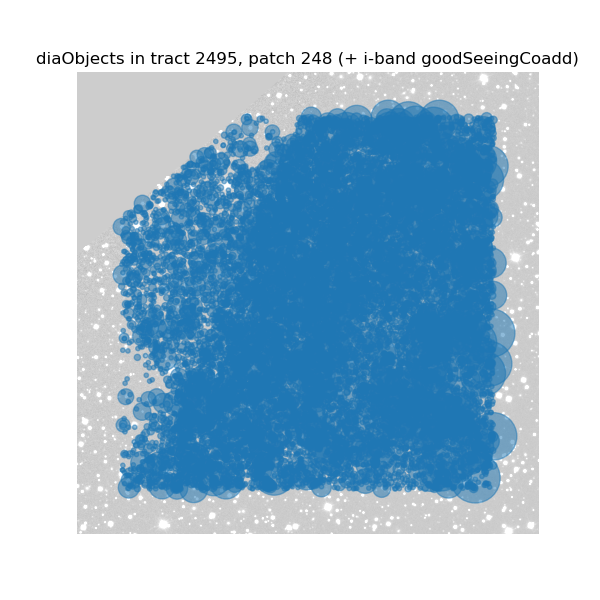

tract 2495, patch 168
There are 138449 total diaSources
There are 136299 "good" diaSources
There are 855 unique visit+detectors
There are 159.4 "good" diaSources per dataId that went into this tract+patch
There are 38998 total diaObjects
	 The diaObject with the most diaSources has 435 diaSources
	 and 26460 (67.8%) diaObjects have just 1 diaSource


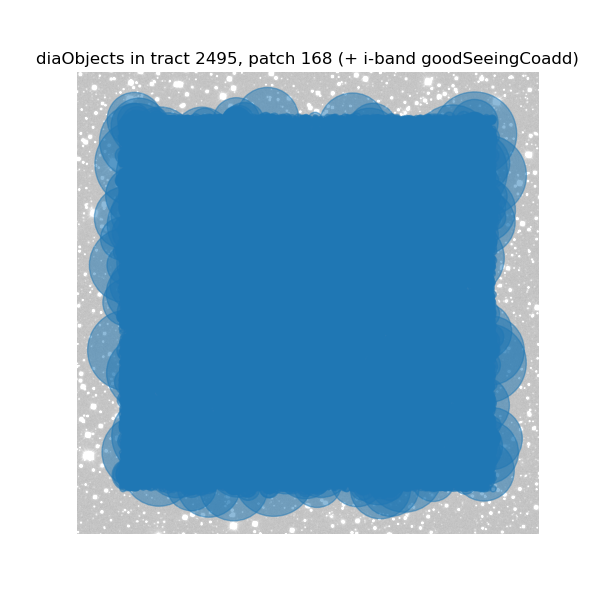

tract 2495, patch 165
There are 91077 total diaSources
There are 89706 "good" diaSources
There are 514 unique visit+detectors
There are 174.5 "good" diaSources per dataId that went into this tract+patch
There are 29183 total diaObjects
	 The diaObject with the most diaSources has 315 diaSources
	 and 21212 (72.7%) diaObjects have just 1 diaSource


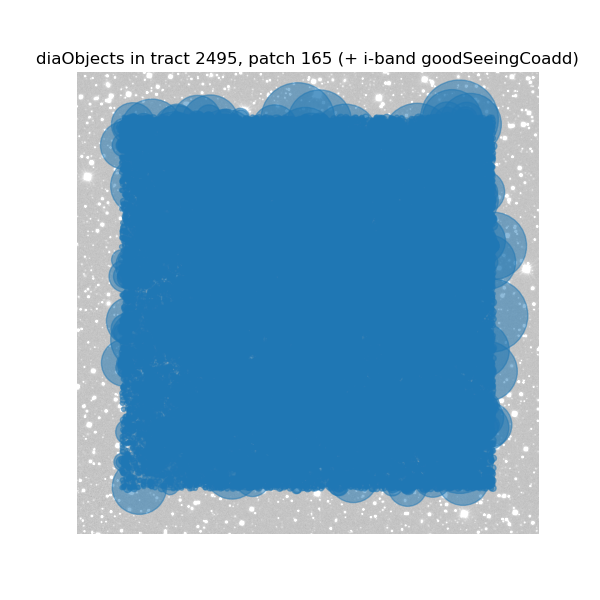

tract 2495, patch 196
There are 15553 total diaSources
There are 15257 "good" diaSources
There are 81 unique visit+detectors
There are 188.4 "good" diaSources per dataId that went into this tract+patch
There are 8142 total diaObjects
	 The diaObject with the most diaSources has 50 diaSources
	 and 6405 (78.7%) diaObjects have just 1 diaSource


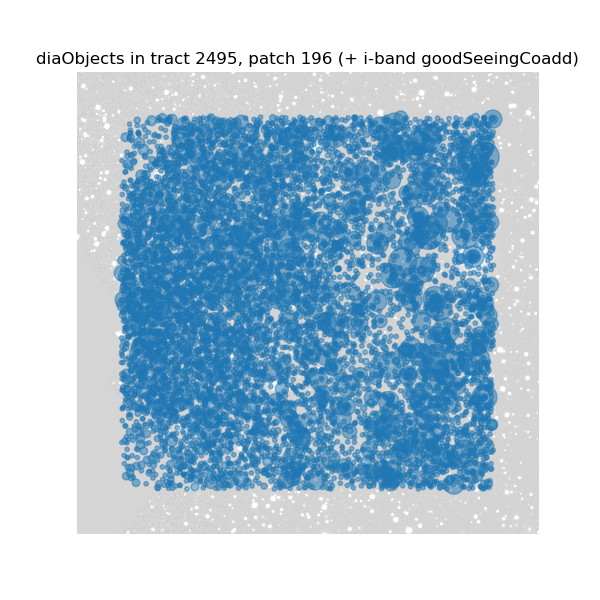

tract 2662, patch 9
There are 15220 total diaSources
There are 14982 "good" diaSources
There are 96 unique visit+detectors
There are 156.1 "good" diaSources per dataId that went into this tract+patch
There are 8256 total diaObjects
	 The diaObject with the most diaSources has 67 diaSources
	 and 6425 (77.8%) diaObjects have just 1 diaSource


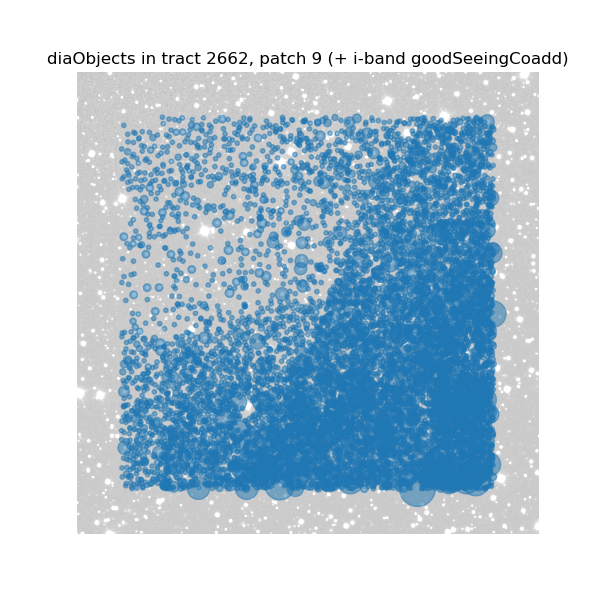

In [246]:
for dataset in uniquePatchList[0:5]:
    result = diaSourceCounter(tract=dataset['tract'], patch=dataset['patch'], doPrintResults=True, butler=drp_butler, instrument='LSSTComCamSim', doMakePlot=True)

### Clearly there are some spatial regions with WAY TOO MANY diaSources. Let's pick a single visit and detector to investigate further.

In [252]:
pp_butler.get('goodSeeingDiff_diaSrcTable', dataId={'detector': 2, 'visit': 7024062700702})

diaSourceId          visit  detector  diaObjectId  ssObjectId  \
0     3068465028014276609  7024062700702         2            0           0   
1     3068465028014276610  7024062700702         2            0           0   
2     3068465028014276611  7024062700702         2            0           0   
3     3068465028014276612  7024062700702         2            0           0   
4     3068465028014276613  7024062700702         2            0           0   
...                   ...            ...       ...          ...         ...   
1299  3068465028014277963  7024062700702         2            0           0   
1300  3068465028014277964  7024062700702         2            0           0   
1301  3068465028014277965  7024062700702         2            0           0   
1302  3068465028014277966  7024062700702         2            0           0   
1303  3068465028014277967  7024062700702         2            0           0   

      parentDiaSourceId ssObjectReassocTime  midpointMjdTai          ra  \
0                     0                 NaT    60489.408068  280.038853   
1                     0                 NaT    60489.408068  279.985011   
2                     0                 NaT    60489.408068  279.975284   
3                     0                 NaT    60489.408068  279.878620   
4                     0                 NaT    60489.408068  279.816277   
...                 ...                 ...             ...         ...   
1299                  0                 NaT    60489.408068  279.906609   
1300                  0                 NaT    60489.408068  279.908932   
1301                  0                 NaT    60489.408068  279.804300   
1302                  0                 NaT    60489.408068  279.978125   
1303                  0                 NaT    60489.408068  280.027530   

         raErr  ...  pixelFlags_saturated  pixelFlags_saturatedCenter  \
0          NaN  ...                 False                       False   
1          NaN  ...                 False                       False   
2          NaN  ...                 False                       False   
3     0.000006  ...                 False                       False   
4          NaN  ...                 False                       False   
...        ...  ...                   ...                         ...   
1299  0.000042  ...                 False                       False   
1300  0.000029  ...                 False                       False   
1301  0.000025  ...                  True                       False   
1302       NaN  ...                 False                       False   
1303  0.000023  ...                 False                       False   

      pixelFlags_suspect  pixelFlags_suspectCenter  pixelFlags_streak  \
0                  False                     False              False   
1                  False                     False              False   
2                  False                     False              False   
3                  False                     False              False   
4                  False                     False              False   
...                  ...                       ...                ...   
1299               False                     False              False   
1300               False                     False              False   
1301               False                     False              False   
1302               False                     False              False   
1303               False                     False              False   

      pixelFlags_streakCenter  pixelFlags_injected  pixelFlags_injectedCenter  \
0                       False                False                      False   
1                       False                False                      False   
2                       False                False                      False   
3                       False                False                      False   
4    

In [253]:
drp_butler.get('goodSeeingDiff_diaSrcTable', dataId={'detector': 2, 'visit': 7024062700702})

diaSourceId          visit  detector band  diaObjectId  \
0     3068465028014276609  7024062700702         2    r            0   
1     3068465028014276610  7024062700702         2    r            0   
2     3068465028014276611  7024062700702         2    r            0   
3     3068465028014276612  7024062700702         2    r            0   
4     3068465028014276613  7024062700702         2    r            0   
...                   ...            ...       ...  ...          ...   
9591  3068465028014286209  7024062700702         2    r            0   
9592  3068465028014286210  7024062700702         2    r            0   
9593  3068465028014286211  7024062700702         2    r            0   
9594  3068465028014286212  7024062700702         2    r            0   
9595  3068465028014286213  7024062700702         2    r            0   

      ssObjectId  parentDiaSourceId  midpointMjdTai  bboxSize  \
0              0                  0    60489.408068        20   
1              0                  0    60489.408068        23   
2              0                  0    60489.408068        16   
3              0                  0    60489.408068        16   
4              0                  0    60489.408068        48   
...          ...                ...             ...       ...   
9591           0                  0    60489.408068        30   
9592           0                  0    60489.408068        14   
9593           0                  0    60489.408068        16   
9594           0                  0    60489.408068        17   
9595           0                  0    60489.408068        14   

                 time_processed  ...  shape_flag_no_pixels  \
0    2024-07-02 02:25:41.911007  ...                 False   
1    2024-07-02 02:25:41.911007  ...                 False   
2    2024-07-02 02:25:41.911007  ...                 False   
3    2024-07-02 02:25:41.911007  ...                 False   
4    2024-07-02 02:25:41.911007  ...                 False   
...                         ...  ...                   ...   
9591 2024-07-02 02:25:41.911007  ...                 False   
9592 2024-07-02 02:25:41.911007  ...                 False   
9593 2024-07-02 02:25:41.911007  ...                 False   
9594 2024-07-02 02:25:41.911007  ...                 False   
9595 2024-07-02 02:25:41.911007  ...                 False   

      shape_flag_not_contained  shape_flag_parent_source  trail_flag_edge  \
0                        False                     False            False   
1                        False                     False            False   
2                        False                     False            False   
3                        False                     False            False   
4                        False                     False            False   
...                        ...                       ...              ...   
9591                     False                     False            False   
9592                     False                     False            False   
9593                     False                     False            False   
9594                     False                     False            False   
9595                     False                     False            False   

      pixelFlags_streak  pixelFlags_streakCenter  pixelFlags_injected  \
0                  True                     True                False   
1                  True                     True                False   
2                  True                     True                False   
3                  True                     True                False   
4                  True                    False                False   
...                 ...                      ...                  ...   
9591               True                     True                False   
9592               True                     True                False   
9593               True                  

In [269]:
one_pp_diaSrcTable = pp_butler.get('goodSeeingDiff_diaSrcTable', dataId={'detector': 2, 'visit': 7024062700702})
one_pp_diffim = pp_butler.get('goodSeeingDiff_differenceExp', dataId={'detector': 2, 'visit': 7024062700702})
one_drp_diaSrcTable = drp_butler.get('goodSeeingDiff_diaSrcTable', dataId={'detector': 2, 'visit': 7024062700702})
one_drp_diffim = drp_butler.get('goodSeeingDiff_differenceExp', dataId={'detector': 2, 'visit': 7024062700702})

one_pp_science = pp_butler.get('initial_pvi', dataId={'detector': 2, 'visit': 7024062700702})
one_pp_template = pp_butler.get('goodSeeingDiff_templateExp', dataId={'detector': 2, 'visit': 7024062700702})
one_drp_science = drp_butler.get('calexp', dataId={'detector': 2, 'visit': 7024062700702})
one_drp_template = drp_butler.get('goodSeeingDiff_templateExp', dataId={'detector': 2, 'visit': 7024062700702})

Text(0.5, 0.98, 'PP science, template, diffim')

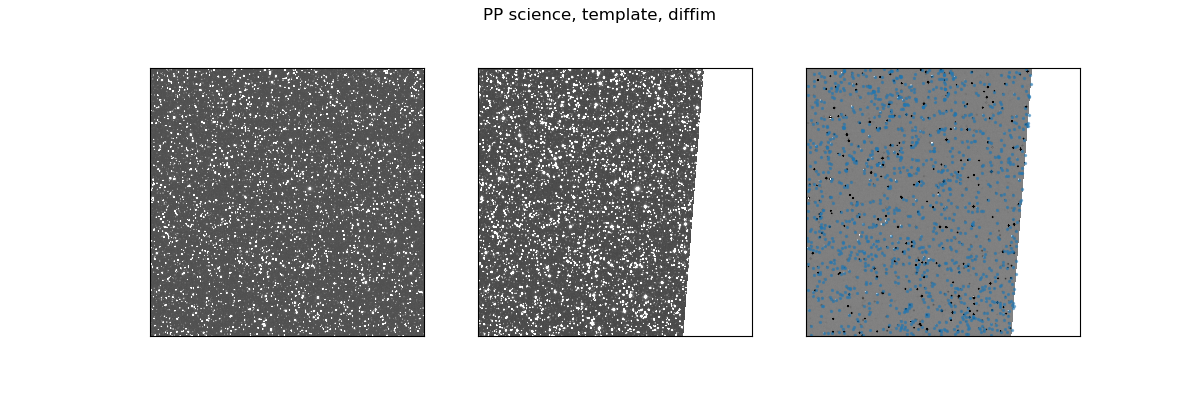

In [415]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
norm_science = ImageNormalize(one_pp_science.image.array, interval=ZScaleInterval())#, stretch=SqrtStretch())
norm_template = ImageNormalize(one_pp_template.image.array, interval=ZScaleInterval())#, stretch=SqrtStretch())
norm_diffim = ImageNormalize(one_pp_diffim.image.array, interval=ZScaleInterval())#, stretch=SqrtStretch())
ax1.imshow(one_pp_science.image.array, origin='lower', norm=norm_science, cmap='gray')
ax2.imshow(one_pp_template.image.array, origin='lower', norm=norm_template, cmap='gray')
ax3.imshow(one_pp_diffim.image.array, origin='lower', norm=norm_diffim, cmap='gray')
ax3.scatter(one_pp_diaSrcTable.x, one_pp_diaSrcTable.y, alpha=0.5, s=2)
ax1.axes.get_xaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax3.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)
fig.suptitle('PP science, template, diffim')

Text(0.5, 0.98, 'DRP science, template, diffim')

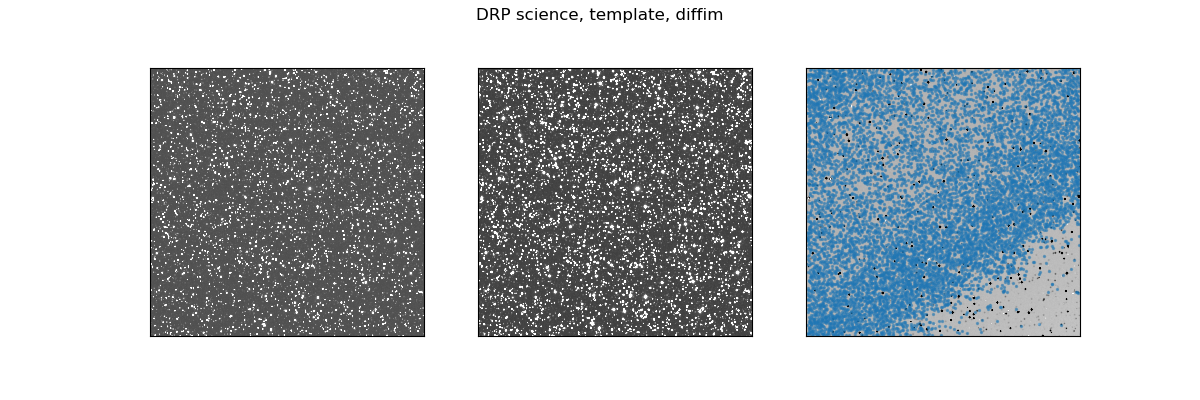

In [416]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
norm_science = ImageNormalize(one_drp_science.image.array, interval=ZScaleInterval())#, stretch=SqrtStretch())
norm_template = ImageNormalize(one_drp_template.image.array, interval=ZScaleInterval())#, stretch=SqrtStretch())
norm_diffim = ImageNormalize(one_drp_diffim.image.array, interval=ZScaleInterval())#, stretch=SqrtStretch())
ax1.imshow(one_drp_science.image.array, origin='lower', norm=norm_science, cmap='gray')
ax2.imshow(one_drp_template.image.array, origin='lower', norm=norm_template, cmap='gray')
ax3.imshow(one_drp_diffim.image.array, origin='lower', norm=norm_diffim, cmap='gray')
ax3.scatter(one_drp_diaSrcTable.x, one_drp_diaSrcTable.y, alpha=0.5, s=2)
ax1.axes.get_xaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax3.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)
fig.suptitle('DRP science, template, diffim')

### Pan-and-zoom afwDisplay versions of the images above

In [466]:
display1 = afwDisplay.Display(dims=(500,500))
display1.setMaskTransparency(20)
display1.mtv(one_drp_diffim)

for index, row in one_drp_diaSrcTable.iterrows():
    #display.dot('+', row.x, row.y, ctype='blue', size=10)
    if not (row['pixelFlags_bad'] | row['pixelFlags_edge'] | row['pixelFlags_suspect']
            | row['pixelFlags_saturated'] | row['pixelFlags_interpolated']
            | row['pixelFlags_interpolatedCenter']):
        display1.dot('+', row['x'], row['y'], ctype='blue', size=10)
    if (row['pixelFlags_bad'] | row['pixelFlags_edge'] | row['pixelFlags_suspect']
        | row['pixelFlags_saturated'] | row['pixelFlags_interpolated']
        | row['pixelFlags_interpolatedCenter']):
        display1.dot('+', row['x'], row['y'], ctype='red', size=10)

display1.embed()

ImageWidget(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\x…

In [465]:
display2 = afwDisplay.Display(dims=(500,500))
display2.setMaskTransparency(20)
display2.mtv(one_pp_diffim)

for index, row in one_pp_diaSrcTable.iterrows():
    if not (row['pixelFlags_bad'] | row['pixelFlags_edge'] | row['pixelFlags_suspect']
            | row['pixelFlags_saturated'] | row['pixelFlags_interpolated']
            | row['pixelFlags_interpolatedCenter']):
        display2.dot('+', row['x'], row['y'], ctype='blue', size=10)
    if (row['pixelFlags_bad'] | row['pixelFlags_edge'] | row['pixelFlags_suspect']
        | row['pixelFlags_saturated'] | row['pixelFlags_interpolated']
        | row['pixelFlags_interpolatedCenter']):
        display2.dot('+', row['x'], row['y'], ctype='red', size=10)

display2.embed()

/opt/lsst/software/stack/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/ginga/util/stages/render.py:634: RuntimeWarning: invalid value encountered in cast
  res_np = res_np.astype(np.uint)


ImageWidget(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\x…

These next two cells show the templates, but I looked at the science images too, and they look normal and fine

In [330]:
display3 = afwDisplay.Display(dims=(500,500))
display3.setMaskTransparency(20)
display3.mtv(one_drp_template)
display3.embed()

ImageWidget(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\x…

In [331]:
display4 = afwDisplay.Display(dims=(500,500))
display4.setMaskTransparency(20)
display4.mtv(one_pp_template)
display4.embed()

/opt/lsst/software/stack/conda/envs/lsst-scipipe-9.0.0/lib/python3.11/site-packages/ginga/util/stages/render.py:634: RuntimeWarning: invalid value encountered in cast
  res_np = res_np.astype(np.uint)


ImageWidget(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\x…

### Look at other relevant data products - like Task Metadata that has metrics in it

Wouldn't it be great if there was some bonkers number in the metrics that could have alerted us to this problem?

In [309]:
one_initialstars_pp = pp_butler.get('initial_stars_footprints_detector', dataId={'detector': 2, 'visit': 7024062700702})

In [321]:
one_pp_psfkernel = pp_butler.get('goodSeeingDiff_psfMatchKernel', dataId={'detector': 2, 'visit': 7024062700702})
one_drp_psfkernel = drp_butler.get('goodSeeingDiff_psfMatchKernel', dataId={'detector': 2, 'visit': 7024062700702})

In [338]:
def printExistingMetadataTypes(butler, collections):
    """List datasetTypes that exist in a given Butler and collections."""
    registry = butler.registry
    for datasetType in registry.queryDatasetTypes():
        if registry.queryDatasets(datasetType, collections=collections).any(execute=False, exact=False):
            # Limit search results to the data products
            if (('_metric' in datasetType.name) or ('_metadata' in datasetType.name)) and ('_log' not in datasetType.name) and ('_resource_usage' not in datasetType.name) and \
               ('wholeSky' not in datasetType.name):
                print(datasetType)

In [339]:
printExistingMetadataTypes(pp_butler, pp_collections)

DatasetType('isr_metadata', {band, instrument, day_obs, detector, group, physical_filter, exposure}, TaskMetadata)
DatasetType('calibrateImage_metadata', {band, instrument, day_obs, detector, physical_filter, visit}, TaskMetadata)
DatasetType('initialPviCore_metadata', {band, instrument, day_obs, detector, physical_filter, visit}, TaskMetadata)
DatasetType('initialPviSummary_metrics', {band, instrument, day_obs, detector, physical_filter, visit}, MetricMeasurementBundle)
DatasetType('retrieveTemplate_metadata', {band, instrument, skymap, day_obs, detector, physical_filter, visit}, TaskMetadata)
DatasetType('subtractImages_metadata', {band, instrument, day_obs, detector, physical_filter, visit}, TaskMetadata)
DatasetType('detectAndMeasure_metadata', {band, instrument, day_obs, detector, physical_filter, visit}, TaskMetadata)
DatasetType('diffimMetadata_metrics', {band, instrument, day_obs, detector, physical_filter, visit}, MetricMeasurementBundle)
DatasetType('diffimTaskCore_metadata',

In [340]:
printExistingMetadataTypes(drp_butler, drp_collections)

DatasetType('isr_metadata', {band, instrument, day_obs, detector, group, physical_filter, exposure}, TaskMetadata)
DatasetType('subtractImages_metadata', {band, instrument, day_obs, detector, physical_filter, visit}, TaskMetadata)
DatasetType('characterizeImage_metadata', {band, instrument, day_obs, detector, physical_filter, visit}, TaskMetadata)
DatasetType('calibrate_metadata', {band, instrument, day_obs, detector, physical_filter, visit}, TaskMetadata)
DatasetType('writePreSourceTable_metadata', {band, instrument, day_obs, detector, physical_filter, visit}, TaskMetadata)
DatasetType('transformPreSourceTable_metadata', {band, instrument, day_obs, detector, physical_filter, visit}, TaskMetadata)
DatasetType('consolidatePreSourceTable_metadata', {band, instrument, day_obs, physical_filter, visit}, TaskMetadata)
DatasetType('consolidateVisitSummary_metadata', {band, instrument, day_obs, physical_filter, visit}, TaskMetadata)
DatasetType('makeMetricTableObjectTableCore_metadata', {skyma

In [341]:
one_detectMeasureMetadata_drp = drp_butler.get('detectAndMeasureDiaSources_metadata', dataId={'detector': 2, 'visit': 7024062700702})

In [342]:
one_detectMeasureMetadata_drp

TaskMetadata(scalars={}, arrays={}, metadata={'detectAndMeasureDiaSources': TaskMetadata(scalars={'__version__': 1.0}, arrays={'runStartUtc': ['2024-07-02T02:22:52.970139+00:00'], 'runStartCpuTime': [102.84512295], 'runStartUserTime': [94.908007], 'runStartSystemTime': [7.937108], 'runStartMaxResidentSetSize': [4532584448.0], 'runStartMinorPageFaults': [3070044.0], 'runStartMajorPageFaults': [0.0], 'runStartBlockInputs': [64.0], 'runStartBlockOutputs': [3593040.0], 'runStartVoluntaryContextSwitches': [116348.0], 'runStartInvoluntaryContextSwitches': [306.0], 'nUnmergedDiaSources': [28607.0], 'nMergedDiaSources': [9605.0], 'nRemovedBadFlaggedSources': [9.0], 'nGoodPixels': [16147618.0], 'nBadPixels': [140382.0], 'nPixelsDetectedPositive': [2773203.0], 'nPixelsDetectedNegative': [770270.0], 'nBadPixelsDetectedPositive': [0.0], 'nBadPixelsDetectedNegative': [0.0], 'bad_mask_fraction': [0.0], 'clipped_mask_fraction': [0.0], 'cr_mask_fraction': [2.9162573673870333e-05], 'detected_mask_fract

In [343]:
one_detectMeasureMetadata_pp = pp_butler.get('detectAndMeasure_metadata', dataId={'detector': 2, 'visit': 7024062700702})

In [344]:
one_detectMeasureMetadata_pp

TaskMetadata(scalars={}, arrays={}, metadata={'detectAndMeasure': TaskMetadata(scalars={'__version__': 1.0}, arrays={'runStartUtc': ['2024-06-28T09:50:48.617278+00:00'], 'runStartCpuTime': [686.289815915], 'runStartUserTime': [601.016748], 'runStartSystemTime': [85.273032], 'runStartMaxResidentSetSize': [9954140160.0], 'runStartMinorPageFaults': [11177641.0], 'runStartMajorPageFaults': [45.0], 'runStartBlockInputs': [3194616.0], 'runStartBlockOutputs': [9618536.0], 'runStartVoluntaryContextSwitches': [322998.0], 'runStartInvoluntaryContextSwitches': [586158.0], 'nUnmergedDiaSources': [5125.0], 'nMergedDiaSources': [1359.0], 'n_skySources': [100.0], 'nRemovedBadFlaggedSources': [16.0], 'nGoodPixels': [16147618.0], 'nBadPixels': [140382.0], 'nPixelsDetectedPositive': [155270.0], 'nPixelsDetectedNegative': [581939.0], 'nBadPixelsDetectedPositive': [0.0], 'nBadPixelsDetectedNegative': [0.0], 'bad_mask_fraction': [0.0], 'clipped_mask_fraction': [0.0], 'cr_mask_fraction': [2.9162573673870333

In [345]:
one_subtractMetadata_drp = drp_butler.get('subtractImages_metadata', {'detector': 2, 'visit': 7024062700702})

In [346]:
one_subtractMetadata_drp

TaskMetadata(scalars={}, arrays={}, metadata={'subtractImages': TaskMetadata(scalars={'__version__': 1.0}, arrays={'runStartUtc': ['2024-07-02T02:21:09.280781+00:00'], 'runStartCpuTime': [61.546442256], 'runStartUserTime': [56.358775], 'runStartSystemTime': [5.187659], 'runStartMaxResidentSetSize': [3604475904.0], 'runStartMinorPageFaults': [2071804.0], 'runStartMajorPageFaults': [0.0], 'runStartBlockInputs': [64.0], 'runStartBlockOutputs': [2552568.0], 'runStartVoluntaryContextSwitches': [82956.0], 'runStartInvoluntaryContextSwitches': [234.0], 'templateCoveragePercent': [99.95694990176818], 'scaleTemplateVarianceFactor': [1.0564019254201282], 'scaleScienceVarianceFactor': [1.007276713033054], 'sciencePsfSize': [2.9712079964342766], 'templatePsfSize': [4.013478124915348], 'scienceLimitingMagnitude': [28.713487802542698], 'templateLimitingMagnitude': [23.91720400032093], 'diffimLimitingMagnitude': [23.917124998758315], 'nPsfSources': [1000.0], 'convolvedExposure': ['Template'], 'runEnd

In [347]:
one_subtractMetadata_pp = pp_butler.get('subtractImages_metadata', {'detector': 2, 'visit': 7024062700702})

In [348]:
one_subtractMetadata_pp

TaskMetadata(scalars={}, arrays={}, metadata={'subtractImages': TaskMetadata(scalars={'__version__': 1.0}, arrays={'runStartUtc': ['2024-06-28T09:50:03.102246+00:00'], 'runStartCpuTime': [643.066994804], 'runStartUserTime': [568.246321], 'runStartSystemTime': [74.820634], 'runStartMaxResidentSetSize': [9954140160.0], 'runStartMinorPageFaults': [9931833.0], 'runStartMajorPageFaults': [41.0], 'runStartBlockInputs': [3187576.0], 'runStartBlockOutputs': [9280024.0], 'runStartVoluntaryContextSwitches': [320135.0], 'runStartInvoluntaryContextSwitches': [585730.0], 'templateCoveragePercent': [79.32244597249509], 'scaleTemplateVarianceFactor': [1.0788214042888633], 'scaleScienceVarianceFactor': [1.0117556770814458], 'sciencePsfSize': [2.9737750607689004], 'templatePsfSize': [4.015293467720561], 'scienceLimitingMagnitude': [28.644551421370352], 'templateLimitingMagnitude': [23.91671436098205], 'diffimLimitingMagnitude': [23.916624744306564], 'nPsfSources': [1000.0], 'convolvedExposure': ['Templ

In [392]:
one_subtractMetadata_pp.names()

{'quantum',
 'quantum.__version__',
 'quantum.endBlockInputs',
 'quantum.endBlockOutputs',
 'quantum.endCpuTime',
 'quantum.endInvoluntaryContextSwitches',
 'quantum.endMajorPageFaults',
 'quantum.endMaxResidentSetSize',
 'quantum.endMinorPageFaults',
 'quantum.endSystemTime',
 'quantum.endUserTime',
 'quantum.endUtc',
 'quantum.endVoluntaryContextSwitches',
 'quantum.initBlockInputs',
 'quantum.initBlockOutputs',
 'quantum.initCpuTime',
 'quantum.initInvoluntaryContextSwitches',
 'quantum.initMajorPageFaults',
 'quantum.initMaxResidentSetSize',
 'quantum.initMinorPageFaults',
 'quantum.initSystemTime',
 'quantum.initUserTime',
 'quantum.initUtc',
 'quantum.initVoluntaryContextSwitches',
 'quantum.prepBlockInputs',
 'quantum.prepBlockOutputs',
 'quantum.prepCpuTime',
 'quantum.prepInvoluntaryContextSwitches',
 'quantum.prepMajorPageFaults',
 'quantum.prepMaxResidentSetSize',
 'quantum.prepMinorPageFaults',
 'quantum.prepSystemTime',
 'quantum.prepUserTime',
 'quantum.prepUtc',
 'quantu

In [402]:
one_detectMeasureMetadata_pp.names()

{'detectAndMeasure',
 'detectAndMeasure.__version__',
 'detectAndMeasure.bad_mask_fraction',
 'detectAndMeasure.clipped_mask_fraction',
 'detectAndMeasure.cr_mask_fraction',
 'detectAndMeasure.detected_mask_fraction',
 'detectAndMeasure.detected_negative_mask_fraction',
 'detectAndMeasure.edge_mask_fraction',
 'detectAndMeasure.inexact_psf_mask_fraction',
 'detectAndMeasure.injected_mask_fraction',
 'detectAndMeasure.injected_template_mask_fraction',
 'detectAndMeasure.intrp_mask_fraction',
 'detectAndMeasure.nBadPixels',
 'detectAndMeasure.nBadPixelsDetectedNegative',
 'detectAndMeasure.nBadPixelsDetectedPositive',
 'detectAndMeasure.nGoodPixels',
 'detectAndMeasure.nMergedDiaSources',
 'detectAndMeasure.nPixelsDetectedNegative',
 'detectAndMeasure.nPixelsDetectedPositive',
 'detectAndMeasure.nRemovedBadFlaggedSources',
 'detectAndMeasure.nUnmergedDiaSources',
 'detectAndMeasure.n_skySources',
 'detectAndMeasure.no_data_mask_fraction',
 'detectAndMeasure.not_deblended_mask_fraction',


In [400]:
one_subtractMetadata_pp['subtractImages.scaleTemplateVarianceFactor']

1.0788214042888633

In [399]:
one_subtractMetadata_drp['subtractImages.scaleTemplateVarianceFactor']

1.0564019254201282

We'll revisit metadata in a slightly more systematic way in a minute.

## Reprocessed one visit with PP pipeline and DRP template - let's take a look

We can rule out the template as the problem if reprocessing a visit with the PP pipeline but the DRP template does NOT show bonkers diaSource counts.

In [404]:
pp_test_collections = 'u/mrawls/PREOPS-5281/PP-with-DRP-templates-OR4'
pp_test_butler = dafButler.Butler(repo, collections=pp_test_collections, instrument=instrument, skymap=skymap)

In [406]:
one_pp_test_diaSrcTable = pp_test_butler.get('goodSeeingDiff_diaSrcTable', dataId={'detector': 2, 'visit': 7024062700702})
one_pp_test_diffim = pp_test_butler.get('goodSeeingDiff_differenceExp', dataId={'detector': 2, 'visit': 7024062700702})
one_pp_test_science = pp_test_butler.get('initial_pvi', dataId={'detector': 2, 'visit': 7024062700702})
one_pp_test_template = pp_test_butler.get('goodSeeingDiff_templateExp', dataId={'detector': 2, 'visit': 7024062700702})

Text(0.5, 0.98, 'PP - reprocessed w/DRP template - science, template, diffim')

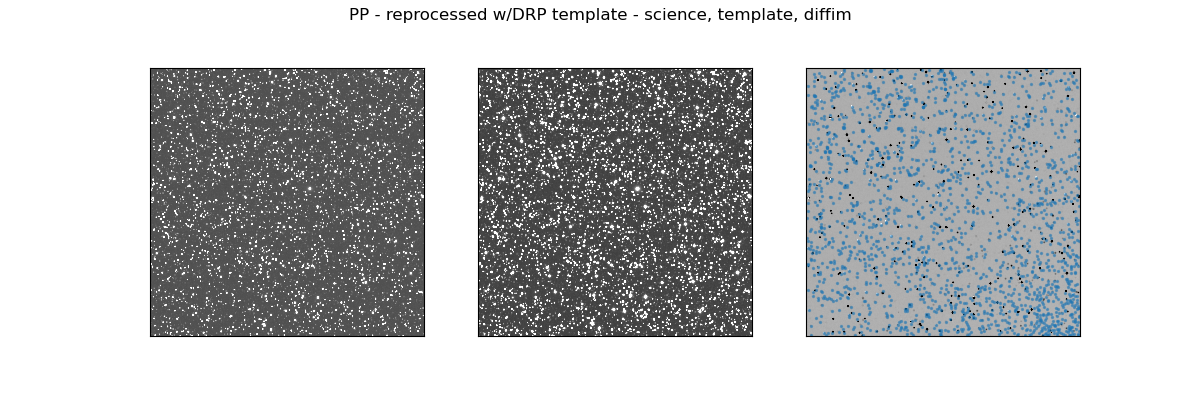

In [417]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
norm_science = ImageNormalize(one_pp_test_science.image.array, interval=ZScaleInterval())#, stretch=SqrtStretch())
norm_template = ImageNormalize(one_pp_test_template.image.array, interval=ZScaleInterval())#, stretch=SqrtStretch())
norm_diffim = ImageNormalize(one_drp_diffim.image.array, interval=ZScaleInterval())#, stretch=SqrtStretch())
ax1.imshow(one_pp_test_science.image.array, origin='lower', norm=norm_science, cmap='gray')
ax2.imshow(one_pp_test_template.image.array, origin='lower', norm=norm_template, cmap='gray')
ax3.imshow(one_pp_test_diffim.image.array, origin='lower', norm=norm_diffim, cmap='gray')
ax3.scatter(one_pp_test_diaSrcTable.x, one_pp_test_diaSrcTable.y, alpha=0.5, s=2)
ax1.axes.get_xaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax3.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)
fig.suptitle('PP - reprocessed w/DRP template - science, template, diffim')

In [422]:
display5 = afwDisplay.Display(dims=(500,500))
display5.setMaskTransparency(20)
display5.mtv(one_pp_test_diffim)

for index, row in one_pp_test_diaSrcTable.iterrows():
    if not (row['pixelFlags_bad'] | row['pixelFlags_edge'] | row['pixelFlags_suspect']
            | row['pixelFlags_saturated'] | row['pixelFlags_interpolated']
            | row['pixelFlags_interpolatedCenter']):
        display5.dot('+', row['x'], row['y'], ctype='blue', size=10)
    if (row['pixelFlags_bad'] | row['pixelFlags_edge'] | row['pixelFlags_suspect']
        | row['pixelFlags_saturated'] | row['pixelFlags_interpolated']
        | row['pixelFlags_interpolatedCenter']):
        display5.dot('+', row['x'], row['y'], ctype='red', size=10)

display5.embed()

ImageWidget(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\x…

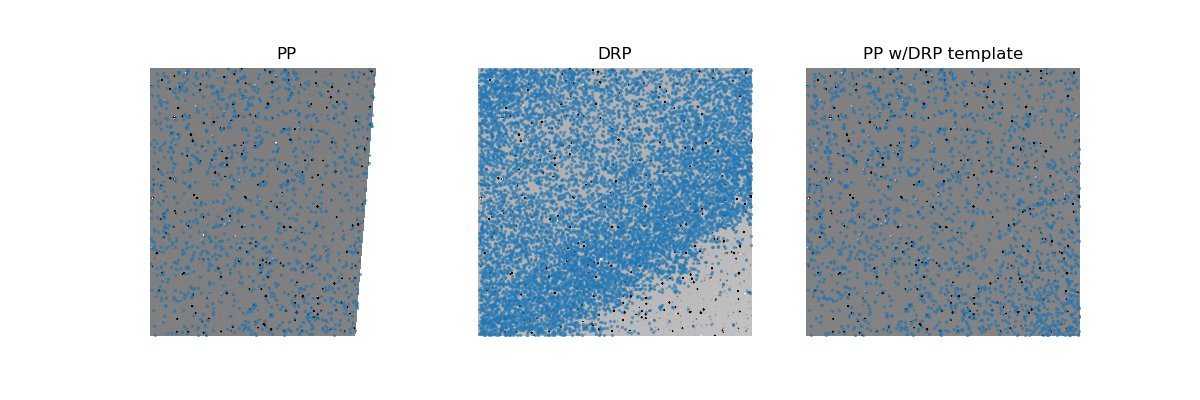

In [425]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
norm_pp = ImageNormalize(one_pp_diffim.image.array, interval=ZScaleInterval())#, stretch=SqrtStretch())
norm_drp = ImageNormalize(one_drp_diffim.image.array, interval=ZScaleInterval())#, stretch=SqrtStretch())
norm_pp_test = ImageNormalize(one_pp_test_diffim.image.array, interval=ZScaleInterval())#, stretch=SqrtStretch())
ax1.imshow(one_pp_diffim.image.array, origin='lower', norm=norm_pp, cmap='gray')
ax1.scatter(one_pp_diaSrcTable.x, one_pp_diaSrcTable.y, alpha=0.5, s=2, label='PP')
ax1.axis('off')
ax1.set_title('PP')
ax2.imshow(one_drp_diffim.image.array, origin='lower', norm=norm_drp, cmap='gray')
ax2.scatter(one_drp_diaSrcTable.x, one_drp_diaSrcTable.y, alpha=0.5, s=2, label='DRP')
ax2.axis('off')
ax2.set_title('DRP')
ax3.imshow(one_pp_test_diffim.image.array, origin='lower', norm=norm_pp_test, cmap='gray')
ax3.scatter(one_pp_test_diaSrcTable.x, one_pp_test_diaSrcTable.y, alpha=0.5, s=2, label='PP w/DRP template')
ax3.axis('off')
ax3.set_title('PP w/DRP template')
plt.show()

In [419]:
one_pp_test_diaSrcTable

diaSourceId          visit  detector  diaObjectId  ssObjectId  \
0     3068465028014276609  7024062700702         2            0           0   
1     3068465028014276610  7024062700702         2            0           0   
2     3068465028014276611  7024062700702         2            0           0   
3     3068465028014276612  7024062700702         2            0           0   
4     3068465028014276613  7024062700702         2            0           0   
...                   ...            ...       ...          ...         ...   
1989  3068465028014278736  7024062700702         2            0           0   
1990  3068465028014278737  7024062700702         2            0           0   
1991  3068465028014278738  7024062700702         2            0           0   
1992  3068465028014278739  7024062700702         2            0           0   
1993  3068465028014278740  7024062700702         2            0           0   

      parentDiaSourceId ssObjectReassocTime  midpointMjdTai          ra  \
0                     0                 NaT    60489.408068  280.038853   
1                     0                 NaT    60489.408068  280.020535   
2                     0                 NaT    60489.408068  279.985011   
3                     0                 NaT    60489.408068  279.975284   
4                     0                 NaT    60489.408068  279.878620   
...                 ...                 ...             ...         ...   
1989                  0                 NaT    60489.408068  279.778882   
1990                  0                 NaT    60489.408068  279.908934   
1991                  0                 NaT    60489.408068  279.804296   
1992                  0                 NaT    60489.408068  279.978125   
1993                  0                 NaT    60489.408068  280.027430   

         raErr  ...  pixelFlags_saturated  pixelFlags_saturatedCenter  \
0          NaN  ...                 False                       False   
1          NaN  ...                 False                       False   
2          NaN  ...                 False                       False   
3          NaN  ...                 False                       False   
4     0.000005  ...                 False                       False   
...        ...  ...                   ...                         ...   
1989       NaN  ...                 False                       False   
1990  0.000030  ...                 False                       False   
1991  0.000028  ...                  True                       False   
1992  0.003102  ...                 False                       False   
1993       NaN  ...                 False                       False   

      pixelFlags_suspect  pixelFlags_suspectCenter  pixelFlags_streak  \
0                  False                     False              False   
1                  False                     False              False   
2                  False                     False              False   
3                  False                     False              False   
4                  False                     False              False   
...                  ...                       ...                ...   
1989               False                     False              False   
1990               False                     False              False   
1991               False                     False              False   
1992               False                     False              False   
1993               False                     False              False   

      pixelFlags_streakCenter  pixelFlags_injected  pixelFlags_injectedCenter  \
0                       False                False                      False   
1                       False                False                      False   
2                       False                False                      False   
3                       False                False                      False   
4    

In [420]:
one_pp_diaSrcTable

diaSourceId          visit  detector  diaObjectId  ssObjectId  \
0     3068465028014276609  7024062700702         2            0           0   
1     3068465028014276610  7024062700702         2            0           0   
2     3068465028014276611  7024062700702         2            0           0   
3     3068465028014276612  7024062700702         2            0           0   
4     3068465028014276613  7024062700702         2            0           0   
...                   ...            ...       ...          ...         ...   
1299  3068465028014277963  7024062700702         2            0           0   
1300  3068465028014277964  7024062700702         2            0           0   
1301  3068465028014277965  7024062700702         2            0           0   
1302  3068465028014277966  7024062700702         2            0           0   
1303  3068465028014277967  7024062700702         2            0           0   

      parentDiaSourceId ssObjectReassocTime  midpointMjdTai          ra  \
0                     0                 NaT    60489.408068  280.038853   
1                     0                 NaT    60489.408068  279.985011   
2                     0                 NaT    60489.408068  279.975284   
3                     0                 NaT    60489.408068  279.878620   
4                     0                 NaT    60489.408068  279.816277   
...                 ...                 ...             ...         ...   
1299                  0                 NaT    60489.408068  279.906609   
1300                  0                 NaT    60489.408068  279.908932   
1301                  0                 NaT    60489.408068  279.804300   
1302                  0                 NaT    60489.408068  279.978125   
1303                  0                 NaT    60489.408068  280.027530   

         raErr  ...  pixelFlags_saturated  pixelFlags_saturatedCenter  \
0          NaN  ...                 False                       False   
1          NaN  ...                 False                       False   
2          NaN  ...                 False                       False   
3     0.000006  ...                 False                       False   
4          NaN  ...                 False                       False   
...        ...  ...                   ...                         ...   
1299  0.000042  ...                 False                       False   
1300  0.000029  ...                 False                       False   
1301  0.000025  ...                  True                       False   
1302       NaN  ...                 False                       False   
1303  0.000023  ...                 False                       False   

      pixelFlags_suspect  pixelFlags_suspectCenter  pixelFlags_streak  \
0                  False                     False              False   
1                  False                     False              False   
2                  False                     False              False   
3                  False                     False              False   
4                  False                     False              False   
...                  ...                       ...                ...   
1299               False                     False              False   
1300               False                     False              False   
1301               False                     False              False   
1302               False                     False              False   
1303               False                     False              False   

      pixelFlags_streakCenter  pixelFlags_injected  pixelFlags_injectedCenter  \
0                       False                False                      False   
1                       False                False                      False   
2                       False                False                      False   
3                       False                False                      False   
4    

In [421]:
one_drp_diaSrcTable

diaSourceId          visit  detector band  diaObjectId  \
0     3068465028014276609  7024062700702         2    r            0   
1     3068465028014276610  7024062700702         2    r            0   
2     3068465028014276611  7024062700702         2    r            0   
3     3068465028014276612  7024062700702         2    r            0   
4     3068465028014276613  7024062700702         2    r            0   
...                   ...            ...       ...  ...          ...   
9591  3068465028014286209  7024062700702         2    r            0   
9592  3068465028014286210  7024062700702         2    r            0   
9593  3068465028014286211  7024062700702         2    r            0   
9594  3068465028014286212  7024062700702         2    r            0   
9595  3068465028014286213  7024062700702         2    r            0   

      ssObjectId  parentDiaSourceId  midpointMjdTai  bboxSize  \
0              0                  0    60489.408068        20   
1              0                  0    60489.408068        23   
2              0                  0    60489.408068        16   
3              0                  0    60489.408068        16   
4              0                  0    60489.408068        48   
...          ...                ...             ...       ...   
9591           0                  0    60489.408068        30   
9592           0                  0    60489.408068        14   
9593           0                  0    60489.408068        16   
9594           0                  0    60489.408068        17   
9595           0                  0    60489.408068        14   

                 time_processed  ...  shape_flag_no_pixels  \
0    2024-07-02 02:25:41.911007  ...                 False   
1    2024-07-02 02:25:41.911007  ...                 False   
2    2024-07-02 02:25:41.911007  ...                 False   
3    2024-07-02 02:25:41.911007  ...                 False   
4    2024-07-02 02:25:41.911007  ...                 False   
...                         ...  ...                   ...   
9591 2024-07-02 02:25:41.911007  ...                 False   
9592 2024-07-02 02:25:41.911007  ...                 False   
9593 2024-07-02 02:25:41.911007  ...                 False   
9594 2024-07-02 02:25:41.911007  ...                 False   
9595 2024-07-02 02:25:41.911007  ...                 False   

      shape_flag_not_contained  shape_flag_parent_source  trail_flag_edge  \
0                        False                     False            False   
1                        False                     False            False   
2                        False                     False            False   
3                        False                     False            False   
4                        False                     False            False   
...                        ...                       ...              ...   
9591                     False                     False            False   
9592                     False                     False            False   
9593                     False                     False            False   
9594                     False                     False            False   
9595                     False                     False            False   

      pixelFlags_streak  pixelFlags_streakCenter  pixelFlags_injected  \
0                  True                     True                False   
1                  True                     True                False   
2                  True                     True                False   
3                  True                     True                False   
4                  True                    False                False   
...                 ...                      ...                  ...   
9591               True                     True                False   
9592               True                     True                False   
9593               True                  

## Metrics of interest

subtractImage:

* templateCoveragePercent
* scaleTemplateVarianceFactor
* scaleScienceVarianceFactor
* sciencePsfSize
* templatePsfSize
* scienceLimitingMagnitude
* templateLimitingMagnitude
* diffimLimitingMagnitude
* nPsfSources
* convolvedExposure

detectAndMeasure:

* nUnmergedDiaSources
* nMergedDiaSources
* n_skySources
* nRemovedBadFlaggedSources
* nGoodPixels
* nBadPixels
* nPixelsDetectedPositive
* nPixelsDetectedNegative
* nBadPixelsDetectedPositive
* nBadPixelsDetectedNegative
* bad_mask_fraction
* clipped_mask_fraction
* cr_mask_fraction
* detected_mask_fraction
* detected_negative_mask_fraction
* edge_mask_fraction
* inexact_psf_mask_fraction
* injected_mask_fraction
* injected_template_mask_fraction
* intrp_mask_fraction
* not_deblended_mask_fraction
* no_data_mask_fraction
* rejected_mask_fraction
* sat_mask_fraction
* sat_template_mask_fraction
* sensor_edge_mask_fraction
* streak_mask_fraction
* suspect_mask_fraction
* unmaskednan_mask_fraction

In [431]:
one_subtractMetadata_pp.metadata.keys()

dict_keys(['subtractImages', 'subtractImages:decorrelate', 'subtractImages:makeKernel', 'subtractImages:makeKernel:background', 'subtractImages:makeKernel:selectDetection', 'subtractImages:makeKernel:selectDetection:tempLocalBackground', 'subtractImages:makeKernel:selectMeasurement', 'subtractImages:scaleVariance', 'subtractImages:scaleVariance:background', 'quantum'])

In [434]:
subtractMetricKeys = ['templateCoveragePercent', 'scaleTemplateVarianceFactor', 'scaleScienceVarianceFactor', 'sciencePsfSize',
                      'templatePsfSize', 'scienceLimitingMagnitude', 'templateLimitingMagnitude', 'diffimLimitingMagnitude',
                      'nPsfSources', 'convolvedExposure']

In [454]:
one_subtractMetadata_pp_test = pp_test_butler.get('subtractImages_metadata', dataId={'detector': 2, 'visit': 7024062700702})
one_detectMeasureMetadata_pp_test = pp_test_butler.get('detectAndMeasure_metadata', dataId={'detector': 2, 'visit': 7024062700702})

In [456]:
for key in subtractMetricKeys:
    pp_value = one_subtractMetadata_pp.metadata['subtractImages'][key]
    drp_value = one_subtractMetadata_drp.metadata['subtractImages'][key]
    pp_test_value = one_subtractMetadata_pp_test.metadata['subtractImages'][key]
    print(f'{key}: \t {pp_value} \t {drp_value} \t {pp_test_value}')

templateCoveragePercent: 	 79.32244597249509 	 99.95694990176818 	 99.95692534381139
scaleTemplateVarianceFactor: 	 1.0788214042888633 	 1.0564019254201282 	 1.056487790230502
scaleScienceVarianceFactor: 	 1.0117556770814458 	 1.007276713033054 	 1.0117556770814458
sciencePsfSize: 	 2.9737750607689004 	 2.9712079964342766 	 2.9737750607689004
templatePsfSize: 	 4.015293467720561 	 4.013478124915348 	 4.013642375293636
scienceLimitingMagnitude: 	 28.644551421370352 	 28.713487802542698 	 28.644551421370352
templateLimitingMagnitude: 	 23.91671436098205 	 23.91720400032093 	 23.917159562653445
diffimLimitingMagnitude: 	 23.916624744306564 	 23.917124998758315 	 23.917069872459994
nPsfSources: 	 1000.0 	 1000.0 	 1000.0
convolvedExposure: 	 Template 	 Template 	 Template


In [443]:
detectMeasureMetricKeys = ['nUnmergedDiaSources', 'nMergedDiaSources', 'nRemovedBadFlaggedSources', 'nGoodPixels',
                           'nBadPixels', 'nPixelsDetectedPositive', 'nPixelsDetectedNegative', 'nBadPixelsDetectedPositive',
                           'nBadPixelsDetectedNegative', 'bad_mask_fraction', 'clipped_mask_fraction', 'cr_mask_fraction', 'detected_mask_fraction',
                           'detected_negative_mask_fraction', 'edge_mask_fraction', 'inexact_psf_mask_fraction', 'injected_mask_fraction',
                           'injected_template_mask_fraction', 'intrp_mask_fraction', 'not_deblended_mask_fraction', 'no_data_mask_fraction',
                           'rejected_mask_fraction', 'sat_mask_fraction', 'sat_template_mask_fraction', 'sensor_edge_mask_fraction',
                           'streak_mask_fraction', 'suspect_mask_fraction', 'unmaskednan_mask_fraction']

In [457]:
for key in detectMeasureMetricKeys:
    pp_value = one_detectMeasureMetadata_pp.metadata['detectAndMeasure'][key]
    drp_value = one_detectMeasureMetadata_drp.metadata['detectAndMeasureDiaSources'][key]
    pp_test_value = one_detectMeasureMetadata_pp_test.metadata['detectAndMeasure'][key]
    print(f'{key}: \t {pp_value} \t {drp_value} \t {pp_test_value}')

nUnmergedDiaSources: 	 5125.0 	 28607.0 	 7115.0
nMergedDiaSources: 	 1359.0 	 9605.0 	 2132.0
nRemovedBadFlaggedSources: 	 16.0 	 9.0 	 21.0
nGoodPixels: 	 16147618.0 	 16147618.0 	 16147618.0
nBadPixels: 	 140382.0 	 140382.0 	 140382.0
nPixelsDetectedPositive: 	 155270.0 	 2773203.0 	 235870.0
nPixelsDetectedNegative: 	 581939.0 	 770270.0 	 763704.0
nBadPixelsDetectedPositive: 	 0.0 	 0.0 	 0.0
nBadPixelsDetectedNegative: 	 0.0 	 0.0 	 0.0
bad_mask_fraction: 	 0.0 	 0.0 	 0.0
clipped_mask_fraction: 	 0.0 	 0.0 	 0.0
cr_mask_fraction: 	 2.9162573673870333e-05 	 2.9162573673870333e-05 	 2.9162573673870333e-05
detected_mask_fraction: 	 0.009532784872298625 	 0.17026049852652259 	 0.014481213163064832
detected_negative_mask_fraction: 	 0.035728082023575636 	 0.04729064341846758 	 0.04688752455795678
edge_mask_fraction: 	 0.007913555992141453 	 0.007913555992141453 	 0.007913555992141453
inexact_psf_mask_fraction: 	 0.0 	 0.0 	 0.0
injected_mask_fraction: 	 0.0 	 0.0 	 0.0
injected_temp

### The only metrics that show any appreciable differences are:

* templateCoveragePercent (we knew this; there's a NO_DATA region in the PP template)
* nUnmergedDiaSources and nMergedDiaSources (this is indeed the crux of the problem)
* nPixelsDetectedPositive (another manifestation of the main problem)
* nPixelsDetectedNegative (there are _slightly_ more in DRP, but the positive ones are way worse)
* detected_mask_fraction (a good metric to keep an eye on for flagging this issue in the future!)
* no_data_mask_fraction (as previously stated)
* streak_mask_fraction (likely a symptom of over-detection, unrelated to this investigation)

In [450]:
def plotFlagImages(exp, flagList=['NO_DATA', 'DETECTED', 'DETECTED_NEGATIVE', 'STREAK']):
    fig = plt.figure(figsize=(10,4))
    #plt.suptitle(dataId)
    fig.add_subplot(1, len(flagList)+1, 1)
    norm = ImageNormalize(exp.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    im = plt.imshow(exp.image.array, origin='lower', norm=norm, cmap='gray')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.gca().axes.yaxis.set_ticklabels([])
    plt.title('diffim')
    i = 1
    for (name, bit) in exp.mask.getMaskPlaneDict().items():
        if name in flagList:
            fig.add_subplot(1, len(flagList)+1, i + 1)
            im = plt.imshow(np.where(exp.mask.array & 2**bit, 1, 0),
                       origin='lower', cmap='GnBu', interpolation='nearest')
            plt.title(name)
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.gca().axes.yaxis.set_ticklabels([])
            i = i + 1
            del im

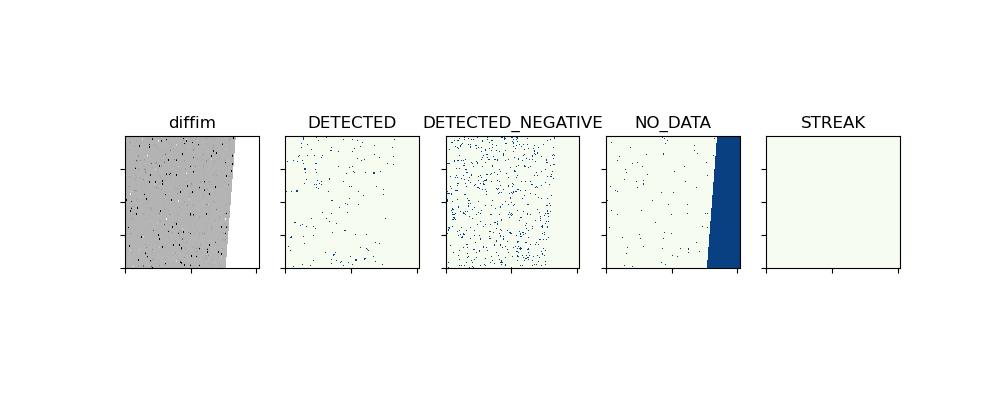

In [451]:
plotFlagImages(one_pp_diffim)

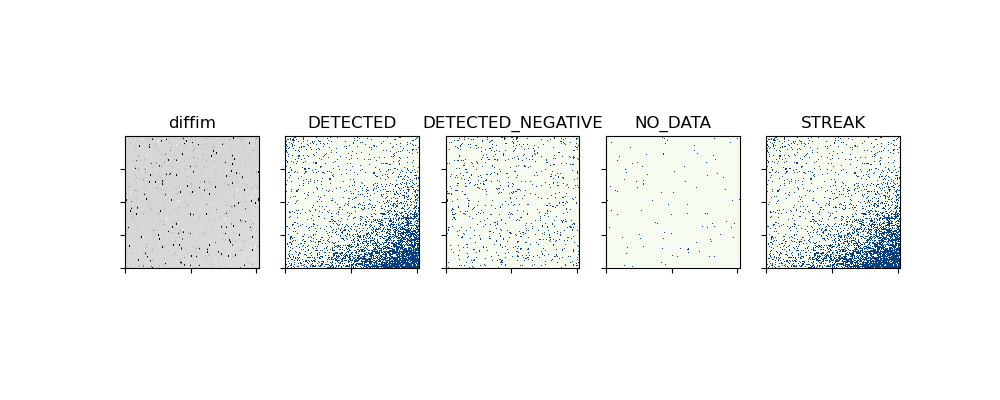

In [452]:
plotFlagImages(one_drp_diffim)

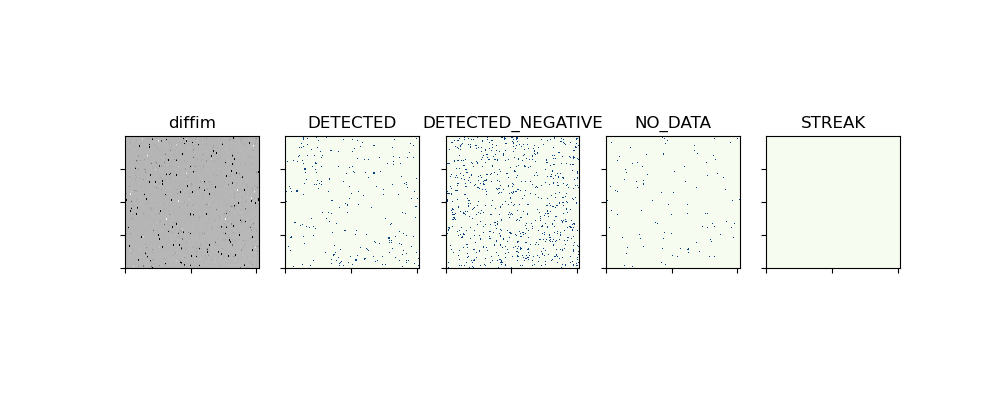

In [467]:
plotFlagImages(one_pp_test_diffim)

In [458]:
one_pp_test_log = pp_test_butler.get('subtractImages_log', dataId={'detector': 2, 'visit': 7024062700702})

In [460]:
one_drp_log = drp_butler.get('subtractImages_log', dataId={'detector': 2, 'visit': 7024062700702})

In [462]:
one_pp_log = pp_butler.get('subtractImages_log', dataId={'detector': 2, 'visit': 7024062700702})